# Telecom Churn Prediction

In the telecommunication industry, customers tend to change operators if not provided with attractive schemes and offers. It is very important for any telecom operator to prevent the present customers from churning to other operators. As a data scientist, your task in this case study would be to build an ML model which can predict if the customer will churn or not in a particular month based on the past data.

#### Objectives

The main goal of the case study is to build ML models to predict churn. The predictive model that you’re going to build will the following purposes:

- It will be used to predict whether a high-value customer will churn or not, in near future (i.e. churn phase). By knowing this, the company can take action steps such as providing special plans, discounts on recharge etc.

- It will be used to identify important variables that are strong predictors of churn. These variables may also indicate why customers choose to switch to other networks.

- Even though overall accuracy will be your primary evaluation metric, you should also mention other metrics like precision, recall, etc. for the different models that can be used for evaluation purposes based on different business objectives. For example, in this problem statement, one business goal can be to build an ML model that identifies customers who'll definitely churn with more accuracy as compared to the ones who'll not churn. Make sure you mention which metric can be used in such scenarios.

- Recommend strategies to manage customer churn based on your observations.

#### Import Libraries

In [262]:
import numpy as np
import pandas as pd

# Importing plot Libraries
import matplotlib.pyplot as plt 
import seaborn as sns

# Importing Data Processing Libraries
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Importing ML Libaries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Import ModelEvaluation Libraries
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

#### Adjusting Output Setting's

In [263]:
# Ignore version warnings
import warnings
warnings.filterwarnings('ignore')

# Setting Pandas Display options
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)

# Print all the output in Notebook instead of ...
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#### Custom Functions for Univariant and BiVariant Plots, Treating the Outliers

In [264]:
def data_type(var):
    if var.dtype == np.int64 or var.dtype == np.float64: return 'num'
    elif var.dtype == 'category': return 'cat'

    
def univar_plot_byCheckingColTyp(df, col, vartype , hue = None):
       
    sns.set(style="darkgrid")
    
    if vartype == 0:
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,6))
        
        ax[0].set_title("Box Plot")
        sns.boxplot(data=df, x=col, ax=ax[0], orient='v')
        
        ax[1].set_title("Distribution Plot")
        sns.distplot(df[col],ax=ax[1])      
    elif vartype == 1:
        temp = pd.Series(data = hue)
        fig, ax = plt.subplots()
        width = len(df[col].unique()) + 6 + 4*len(temp.unique())
        fig.set_size_inches(width , 7)
        ax = sns.countplot(data = df, x=col, order=df[col].value_counts().index, hue=hue) 
        if len(temp.unique()) > 0:
            for p in ax.patches:
                ax.annotate('{:1.1f}%'.format((p.get_height()*100)/float(len(df))), (p.get_x()+0.05, p.get_height()+20))  
        else:
            for p in ax.patches:
                ax.annotate(p.get_height(), (p.get_x()+0.32, p.get_height()+20)) 
        del temp
    else:
        print('Wrong Variable Type is passed, please check.')
        exit
        
    plt.show()
    
    
def univariate(df, col, stats=True):
    
    if data_type(df[col]) == 'num':
        univar_plot_byCheckingColTyp(df, col, 0)
        if stats == True:
            print(df[col].describe())
    
    elif data_type(df[col]) == 'cat':
        univar_plot_byCheckingColTyp(df, col, 1)
        if stats == True:
            print(df[col].value_counts())
            
    else:
        print("Invalid variable passed: either pass a numeric variable or a categorical vairable.")

        
def bivariate(df, var1, var2):
    if data_type(df[var1]) == 'num' and data_type(df[var2]) == 'num':
        sns.regplot(df[var1], df[var2])
    elif (data_type(df[var1]) == 'cat' and data_type(df[var2]) == 'num') or (data_type(df[var1]) == 'num' and data_type(df[var2]) == 'cat'):
        sns.boxplot(df[var1], df[var2])
        
        
## Standard Deviation Outlier Treatment 
def std_dev_cap_outliers(data, k = 10):
    upper_limit = data.mean() + k * data.std()
    lower_limit = data.mean() - k * data.std()
    data[data < lower_limit] = lower_limit
    data[data > upper_limit] = upper_limit
    return data
   

#### Data Understanding

<table align="left">
<tr><th>Acronyms</th><th>Description</th></tr>    
<tr><td>CIRCLE_ID</td><td>Telecom circle area to which the customer belongs to</td></tr>
<tr><td>LOC</td><td>Local calls  within same telecom circle</td></tr>
<tr><td>STD</td><td>STD calls  outside the calling circle</td></tr>
<tr><td>IC</td><td>Incoming calls</td></tr>
<tr><td>OG</td><td>Outgoing calls</td></tr>
<tr><td>T2T</td><td>Operator T to T ie within same operator mobile to mobile</td></tr>
<tr><td>T2M    </td><td>Operator T to other operator mobile</td></tr>
<tr><td>T2O    </td><td>Operator T to other operator fixed line</td></tr>
<tr><td>T2F    </td><td>Operator T to fixed lines of T</td></tr>
<tr><td>T2C    </td><td>Operator T to its own call center</td></tr>
<tr><td>ARPU    </td><td>Average revenue per user</td></tr>
<tr><td>MOU    </td><td>Minutes of usage  voice calls</td></tr>
<tr><td>AON    </td><td>Age on network  number of days the customer is using the operator T network</td></tr>
<tr><td>ONNET   </td><td>All kind of calls within the same operator network</td></tr>
<tr><td>OFFNET    </td><td>All kind of calls outside the operator T network</td></tr>
<tr><td>ROAM</td><td>Indicates that customer is in roaming zone during the call</td></tr>
<tr><td>SPL   </td><td>Special calls</td></tr>
<tr><td>ISD    </td><td>ISD calls</td></tr>
<tr><td>RECH    </td><td>Recharge</td></tr>
<tr><td>NUM    </td><td>Number</td></tr>
<tr><td>AMT    </td><td>Amount in local currency</td></tr>
<tr><td>MAX    </td><td>Maximum</td></tr>
<tr><td>DATA    </td><td>Mobile internet</td></tr>
<tr><td>3G    </td><td>G network</td></tr>
<tr><td>AV    </td><td>Average</td></tr>
<tr><td>VOL    </td><td>Mobile internet usage volume in MB</td></tr>
<tr><td>2G    </td><td>G network</td></tr>
<tr><td>PCK    </td><td>Prepaid service schemes called  PACKS</td></tr>
<tr><td>NIGHT    </td><td>Scheme to use during specific night hours only</td></tr>
<tr><td>MONTHLY    </td><td>Service schemes with validity equivalent to a month</td></tr>
<tr><td>SACHET   </td><td>Service schemes with validity smaller than a month</td></tr>
<tr><td>*.6    </td><td>KPI for the month of June</td></tr>
<tr><td>*.7    </td><td>KPI for the month of July</td></tr>
<tr><td>*.8    </td><td>KPI for the month of August</td></tr>
<tr><td>FB_USER</td><td>Service scheme to avail services of Facebook and similar social networking sites</td></tr>
<tr><td>VBC    </td><td>Volume based cost  when no specific scheme is not purchased and paid as per usage</td></tr>
</table>

In [265]:
#Loading the train and test data.

df_train = pd.read_csv('train.csv')
df_test_unseen = pd.read_csv('test (1).csv')

RESULT_TEST_FILEPATH = './result_Tegbirsingh_Jagadeeshjunjuri.csv'

#removing the predictor column - churn probability from train dataset
df_train = df_train.drop(columns=['churn_probability'])

In [266]:
# Checking Headers
df_train.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,0.0,0.0,0.00,0.0,0.00,2.23,0.00,0.28,5.29,16.04,2.33,0.00,0.00,0.00,0.00,0.00,0.00,7.53,16.04,2.61,46.34,124.38,1.01,18.75,80.61,0.0,0.00,0.0,0.0,0.0,0.0,0.0,65.09,204.99,1.01,0.0,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,2.43,3.68,7.79,0.83,21.08,16.91,0.00,0.00,0.00,3.26,24.76,24.71,0.00,7.61,0.21,7.46,19.96,14.96,0.0,0.0,0.0,0.0,0.0,0.0,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.0,0.0,0.0,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,6/22/2014,7/10/2014,8/24/2014,65,65,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.00,0.00,0.0,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.01,29.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,1.68,19.09,10.53,1.41,18.68,11.09,0.35,1.66,3.40,3.44,39.44,25.03,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,6/12/2014,7/10/2014,8/26/2014,0,0,0,NaN,7/8/2014,NaN,NaN,1.0,NaN,NaN,145.0,NaN,NaN,0.0,NaN,NaN,1.0,NaN,NaN,145.0,NaN,0.0,352.

In [267]:
# Checking Footer
df_train.tail()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
69994,69994,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,15.760,410.924,329.136,0.00,7.36,10.93,0.00,488.46,381.64,14.96,0.0,0.0,0.00,0.0,0.0,0.00,2.44,7.19,0.00,60.64,89.66,0.00,0.00,0.00,0.0,2.43,0.86,0.00,63.09,96.86,0.00,4.91,3.73,0.00,414.61,290.14,0.0,0.0,0.0,0.0,0.0,0.0,0.00,419.53,293.88,0.00,0.0,0.0,0.00,14.05,1.83,0.0,0.0,0.0,0.00,496.68,392.58,0.00,26.59,33.84,0.00,172.33,223.91,0.00,1.06,0.00,0.00,199.99,257.76,0.00,0.00,0.00,0.00,21.99,11.79,0.0,0.0,0.00,0.0,0.0,0.0,0.00,21.99,11.79,0.00,221.99,269.56,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,1,17,13,50,397,512,50,110,130,6/18/2014,7/31/2014,8/31/2014,50,20,130,NaN,7/31/2014,8/21/2014,NaN,7.0,1.0,NaN,25.0,17.0,NaN,6.0,1.0,NaN,1.0,0.0,NaN,135.0,17.0,0.00,244.59,144.31,0.00,0.00,0.00,NaN,21.91,0.00,NaN,60.61,48.00,NaN,0.0,0.0,0,0,0,0,6,1,0,0,0,0,1,0,NaN,1.0,1.0,221,0.00,0.00,0.00
69995,69995,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,160.083,289.129,265.772,116.54,196.46,232.63,49.53,96.28,48.06,0.00,0.0,0.0,0.00,0.0,0.0,7.18,30.11,9.06,37.53,73.84,47.34,2.01,0.00,0.00,0.0,4.01,0.00,46.73,103.96,56.41,109.36,166.34,223.56,9.98,18.41,0.53,0.0,0.0,0.0,0.0,0.0,0.0,119.34,184.76,224.09,0.00,0.0,0.0,0.13,4.01,0.18,0.0,0.0,0.0,166.21,292.74,280.69,30.48,28.48,23.09,21.78,35.18,28.79,2.38,0.21,0.00,54.64,63.88,51.89,16.63,39.23,66.28,8.96,9.31,17.24,0.0,0.0,0.00,0.0,0.0,0.0,25.59,48.54,83.53,80.24,112.43,136.01,0.0,0.0,0.5,0.00,0.0,0.00,0.00,0.00,0.08,5,11,9,200,313,308,90,44,44,6/28/

In [268]:
# Checking count of Rows and Columns in Dataset and View List of Data Types and count of columns
print('Train Data Details')
print(df_train.shape)
print(df_train.info())

Train Data Details
(69999, 171)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 171 entries, id to jun_vbc_3g
dtypes: float64(135), int64(27), object(9)
memory usage: 91.3+ MB
None


In [269]:
print('Test Data Details')
print(df_test_unseen.shape)
print(df_test_unseen.info())

Test Data Details
(30000, 171)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Columns: 171 entries, id to jun_vbc_3g
dtypes: float64(135), int64(27), object(9)
memory usage: 39.1+ MB
None


In [270]:
#Checking all columns and their Types for train data
print(df_train.dtypes)

id                            int64
circle_id                     int64
loc_og_t2o_mou              float64
std_og_t2o_mou              float64
loc_ic_t2o_mou              float64
last_date_of_month_6         object
last_date_of_month_7         object
last_date_of_month_8         object
arpu_6                      float64
arpu_7                      float64
arpu_8                      float64
onnet_mou_6                 float64
onnet_mou_7                 float64
onnet_mou_8                 float64
offnet_mou_6                float64
offnet_mou_7                float64
offnet_mou_8                float64
roam_ic_mou_6               float64
roam_ic_mou_7               float64
roam_ic_mou_8               float64
roam_og_mou_6               float64
roam_og_mou_7               float64
roam_og_mou_8               float64
loc_og_t2t_mou_6            float64
loc_og_t2t_mou_7            float64
loc_og_t2t_mou_8            float64
loc_og_t2m_mou_6            float64
loc_og_t2m_mou_7            

In [271]:
# Statistical description of Data
df_train.describe(include='all')

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
count,69999.000000,69999.0,69297.0,69297.0,69297.0,69999,69600,69266,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.0,67312.0,66296.0,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.0,67312.0,66296.0,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,68898,68765,67538,69999.000000,69999.000000,69999.000000,1756

In [272]:
df_test_unseen.describe(include='all')

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
count,30000.000000,30000.0,29684.0,29684.0,29684.0,30000,29798,29633,30000.000000,30000.000000,30000.000000,28831.000000,28828.000000,28325.000000,28831.000000,28828.000000,28325.000000,28831.000000,28828.000000,28325.000000,28831.000000,28828.000000,28325.000000,28831.000000,28828.000000,28325.000000,28831.000000,28828.000000,28325.000000,28831.000000,28828.000000,28325.000000,28831.000000,28828.000000,28325.000000,28831.000000,28828.000000,28325.000000,28831.000000,28828.000000,28325.000000,28831.000000,28828.000000,28325.000000,28831.000000,28828.000000,28325.000000,28831.0,28828.0,28325.0,28831.000000,28828.000000,28325.000000,28831.000000,28828.000000,28325.000000,28831.000000,28828.000000,28325.000000,28831.000000,28828.000000,28325.000000,30000.000000,30000.000000,30000.000000,28831.000000,28828.000000,28325.000000,28831.000000,28828.000000,28325.000000,28831.000000,28828.000000,28325.000000,28831.000000,28828.000000,28325.000000,28831.000000,28828.000000,28325.000000,28831.000000,28828.000000,28325.000000,28831.000000,28828.000000,28325.000000,28831.0,28828.0,28325.0,28831.000000,28828.000000,28325.000000,30000.000000,30000.000000,30000.000000,28831.000000,28828.000000,28325.000000,28831.000000,28828.000000,28325.000000,28831.000000,28828.000000,28325.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,29494,29467,28839,30000.000000,30000.000000,30000.000000,7585

able to see Train data have Null values, outliers, No unique values in column data and also some have only one unique data in columns 

In [273]:
df_train.id.nunique()

69999

In [274]:
df_train.circle_id.nunique()

1

Observation: able to see id column have incremental values and circle id column have only one value

In [275]:
#Checking emptry rows in training dataset
empty_rows = df_train.isnull().all(axis=1).sum()
print(f'No. Empty Rows: {empty_rows}')

No. Empty Rows: 0


In [276]:
#Checking empty columns in training dataset
empty_columns = df_train.isnull().all(axis=0).sum()
print(f'No. Empty Columns: {empty_columns}')

No. Empty Columns: 0


Observation: No Blank rows and deleted columns where there is no data.

In [277]:
#Percentage of Null values in each columns in train dataset 
(df_train.isnull().sum()/df_train.shape[0] *100).sort_values(ascending = False)

arpu_3g_6                   74.902499
count_rech_3g_6             74.902499
fb_user_6                   74.902499
night_pck_user_6            74.902499
total_rech_data_6           74.902499
max_rech_data_6             74.902499
count_rech_2g_6             74.902499
date_of_last_rech_data_6    74.902499
av_rech_amt_data_6          74.902499
arpu_2g_6                   74.902499
night_pck_user_7            74.478207
arpu_2g_7                   74.478207
fb_user_7                   74.478207
arpu_3g_7                   74.478207
count_rech_2g_7             74.478207
av_rech_amt_data_7          74.478207
max_rech_data_7             74.478207
count_rech_3g_7             74.478207
total_rech_data_7           74.478207
date_of_last_rech_data_7    74.478207
night_pck_user_8            73.689624
arpu_3g_8                   73.689624
arpu_2g_8                   73.689624
count_rech_3g_8             73.689624
total_rech_data_8           73.689624
av_rech_amt_data_8          73.689624
max_rech_dat

In [278]:
#Percentage of Null values in each columns in test dataset 
(df_test_unseen.isnull().sum()/df_test_unseen.shape[0] *100).sort_values(ascending = False)

arpu_3g_6                   74.716667
count_rech_3g_6             74.716667
fb_user_6                   74.716667
night_pck_user_6            74.716667
total_rech_data_6           74.716667
max_rech_data_6             74.716667
count_rech_2g_6             74.716667
date_of_last_rech_data_6    74.716667
av_rech_amt_data_6          74.716667
arpu_2g_6                   74.716667
night_pck_user_7            74.313333
arpu_2g_7                   74.313333
fb_user_7                   74.313333
arpu_3g_7                   74.313333
count_rech_2g_7             74.313333
av_rech_amt_data_7          74.313333
max_rech_data_7             74.313333
count_rech_3g_7             74.313333
total_rech_data_7           74.313333
date_of_last_rech_data_7    74.313333
night_pck_user_8            73.593333
arpu_3g_8                   73.593333
arpu_2g_8                   73.593333
count_rech_3g_8             73.593333
total_rech_data_8           73.593333
av_rech_amt_data_8          73.593333
max_rech_dat

####  Data Cleaning and Manipulation

In [279]:
# Creating a copy of 'df_train' to clean & transform data
df_train_cleaned = df_train
df_test_unseen_cleaned = df_test_unseen

In [280]:
#as features count is too high, let's try to seperate them w.r.t data understanding.
id_cols = ['id', 'circle_id']

date_cols = ['last_date_of_month_6',
             'last_date_of_month_7',
             'last_date_of_month_8',
             'date_of_last_rech_6',
             'date_of_last_rech_7',
             'date_of_last_rech_8',
             'date_of_last_rech_data_6',
             'date_of_last_rech_data_7',
             'date_of_last_rech_data_8'
            ]

cat_cols =  ['night_pck_user_6',
             'night_pck_user_7',
             'night_pck_user_8',
             'fb_user_6',
             'fb_user_7',
             'fb_user_8'
            ]

In [281]:
num_cols = [column for column in df_train.columns if column not in (id_cols + date_cols + cat_cols)]

# Print the number of columns in each list
print("ID columns: ", len(id_cols))
print("DATE columns: ", len(date_cols)) 
print("Numeric cols: ", len(num_cols))
print("Category cols: ", len(cat_cols))
print("TOTAL SUM: ", len(id_cols) + len(date_cols) + len(num_cols) + len(cat_cols))
print("TOTAL Columns: ", df_train.shape[1])

# Validate if we have missed any column or not
print("Checking segregation is done correctly : ",len(id_cols) + len(date_cols) + len(num_cols) + len(cat_cols) == df_train.shape[1])


ID columns:  2
DATE columns:  9
Numeric cols:  154
Category cols:  6
TOTAL SUM:  171
TOTAL Columns:  171
Checking segregation is done correctly :  True


In [282]:
# some recharge data columns have minimum value of 1 while some don't
rech_cols = ['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8',
                 'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8',
                 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8',
                 'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8',
                 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8'
                 ]

df_train_cleaned[rech_cols].describe(include='all')

,total_rech_data_6,total_rech_data_7,total_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8
count,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000
mean,2.467612,2.679989,2.652441,1.865323,2.056311,2.016018,0.602288,0.623678,0.636423,126.500000,126.402071,125.374925,192.831096,201.455940,196.815792
std,2.794610,3.073472,3.101265,2.566377,2.799916,2.728246,1.279297,1.401230,1.457058,109.352573,109.459266,109.648799,190.623115,198.346141,192.280532
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,25.000000,25.000000,25.000000,82.000000,92.000000,84.000000
50%,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,145.000000,145.000000,145.000000,154.000000,154.000000,154.000000
75%,3.000000,3.000000,3.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,177.000000,177.000000,179.000000,252.000000,252.000000,252.000000
max,61.000000,54.000000,60.000000,42.000000,48.000000,44.000000,29.000000,34.000000,45.000000,1555.000000,1555.000000,1555.000000,5920.000000,4365.000000,4076.000000


In [283]:
# Recharge date and the recharge value are missing in same month, that is customer not recharged service in that particular month
df_train_cleaned.loc[df_train_cleaned.total_rech_data_6.isnull() & df_train_cleaned.date_of_last_rech_data_6.isnull(), ["total_rech_data_6", "date_of_last_rech_data_6"]].head(5)
df_train_cleaned.loc[df_train_cleaned.total_rech_data_7.isnull() & df_train_cleaned.date_of_last_rech_data_7.isnull(), ["total_rech_data_7", "date_of_last_rech_data_7"]].head(5)
df_train_cleaned.loc[df_train_cleaned.total_rech_data_8.isnull() & df_train_cleaned.date_of_last_rech_data_8.isnull(), ["total_rech_data_8", "date_of_last_rech_data_8"]].head(5)
df_train_cleaned[["total_rech_data_6", "date_of_last_rech_data_6","total_rech_data_7", "date_of_last_rech_data_7","total_rech_data_8", "date_of_last_rech_data_8"]].head()

,total_rech_data_6,date_of_last_rech_data_6
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
5,NaN,NaN


,total_rech_data_7,date_of_last_rech_data_7
0,NaN,NaN
2,NaN,NaN
3,NaN,NaN
5,NaN,NaN
6,NaN,NaN


,total_rech_data_8,date_of_last_rech_data_8
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
5,NaN,NaN


,total_rech_data_6,date_of_last_rech_data_6,total_rech_data_7,date_of_last_rech_data_7,total_rech_data_8,date_of_last_rech_data_8
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,1.0,7/8/2014,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,7.0,6/25/2014,7.0,7/23/2014,6.0,8/20/2014


Observation: we recharge is not done in the month, then there is no record available that means we can simply replace null values with 0 


In [284]:
# List of recharge columns where we will impute missing values with 0s
impute_0s = ['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8',
             'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8']

In [285]:
# impute missing values with 0
df_train_cleaned[impute_0s] = df_train_cleaned[impute_0s].fillna(0)
df_test_unseen_cleaned[impute_0s] = df_test_unseen[impute_0s].fillna(0)

In [286]:
# Verifying the recharge columns with manual imputation
print("Missing value parcentage TRAIN:")
print(df_train_cleaned[impute_0s].isnull().sum()*100/df_train_cleaned.shape[1])

# Verification of 0s imputation (TEST)
print("Missing value parcentage TEST:")
print(df_train_cleaned[impute_0s].isnull().sum()*100/df_train_cleaned.shape[1])

Missing value parcentage TRAIN:
total_rech_data_6     0.0
total_rech_data_7     0.0
total_rech_data_8     0.0
av_rech_amt_data_6    0.0
av_rech_amt_data_7    0.0
av_rech_amt_data_8    0.0
max_rech_data_6       0.0
max_rech_data_7       0.0
max_rech_data_8       0.0
dtype: float64
Missing value parcentage TEST:
total_rech_data_6     0.0
total_rech_data_7     0.0
total_rech_data_8     0.0
av_rech_amt_data_6    0.0
av_rech_amt_data_7    0.0
av_rech_amt_data_8    0.0
max_rech_data_6       0.0
max_rech_data_7       0.0
max_rech_data_8       0.0
dtype: float64


In [287]:
# Lets see rech columns stats for train dataset
df_train_cleaned[impute_0s].describe(include='all')

,total_rech_data_6,total_rech_data_7,total_rech_data_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8
count,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000
mean,0.619309,0.683981,0.697867,48.395787,51.415168,51.782975,31.748339,32.260075,32.986614
std,1.762010,1.943193,1.973434,126.923180,133.246541,131.291162,77.519536,78.069163,78.808337
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,8.000000,17.000000,23.000000,8.000000,14.000000,17.000000
max,61.000000,54.000000,60.000000,5920.000000,4365.000000,4076.000000,1555.000000,1555.000000,1555.000000


In [288]:
# Lets see rech columns stats for test dataset
df_test_unseen_cleaned[impute_0s].describe(include='all')

,total_rech_data_6,total_rech_data_7,total_rech_data_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,0.620700,0.676833,0.700033,48.561194,51.342741,52.596458,31.894033,32.747533,33.407933
std,1.757138,1.879782,1.939874,129.640618,131.180208,130.929389,76.614487,78.976636,79.023333
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,14.000000,17.000000,23.000000,14.000000,17.000000,17.000000
max,55.000000,44.000000,57.000000,7546.000000,3765.000000,2520.000000,1555.000000,1555.000000,1555.000000


In [289]:
# we can drop id columns and date columns as there is not much significance
df_train_cleaned = df_train_cleaned.drop(id_cols + date_cols, axis=1)
df_train_cleaned.shape

(69999, 160)

In [290]:
# doing the same for test data
df_test_unseen_cleaned = df_test_unseen_cleaned.drop(id_cols + date_cols, axis=1)
df_train_cleaned.shape

(69999, 160)

#### Fixing Null values for Category columns


In [291]:
for col in cat_cols:
    print(col, df_train_cleaned[col].unique())

night_pck_user_6 [nan  0.  1.]
night_pck_user_7 [nan  0.  1.]
night_pck_user_8 [nan  0.  1.]
fb_user_6 [nan  1.  0.]
fb_user_7 [nan  1.  0.]
fb_user_8 [nan  1.  0.]


able to see cat columns already have 0 values, we can replace null values with -1

In [292]:
df_train_cleaned[cat_cols] = df_train_cleaned[cat_cols].fillna(-1)
df_test_unseen_cleaned[cat_cols] = df_test_unseen_cleaned[cat_cols].fillna(-1)

In [293]:
# Verifying the category columns with manual imputation
print("Missing value parcentage TRAIN:")
print(df_train_cleaned[cat_cols].isnull().sum()*100/df_train_cleaned.shape[1])

print("Missing value parcentage TEST:")
print(df_test_unseen_cleaned[cat_cols].isnull().sum()*100/df_test_unseen_cleaned.shape[1])

Missing value parcentage TRAIN:
night_pck_user_6    0.0
night_pck_user_7    0.0
night_pck_user_8    0.0
fb_user_6           0.0
fb_user_7           0.0
fb_user_8           0.0
dtype: float64
Missing value parcentage TEST:
night_pck_user_6    0.0
night_pck_user_7    0.0
night_pck_user_8    0.0
fb_user_6           0.0
fb_user_7           0.0
fb_user_8           0.0
dtype: float64


#### dropping columns if null values are more than 70%

In [294]:
(df_train.isnull().sum()/df_train.shape[0] *100).sort_values(ascending = False)

arpu_2g_6                   74.902499
night_pck_user_6            74.902499
count_rech_3g_6             74.902499
date_of_last_rech_data_6    74.902499
count_rech_2g_6             74.902499
arpu_3g_6                   74.902499
fb_user_6                   74.902499
fb_user_7                   74.478207
night_pck_user_7            74.478207
date_of_last_rech_data_7    74.478207
arpu_2g_7                   74.478207
arpu_3g_7                   74.478207
count_rech_2g_7             74.478207
count_rech_3g_7             74.478207
arpu_3g_8                   73.689624
arpu_2g_8                   73.689624
night_pck_user_8            73.689624
fb_user_8                   73.689624
count_rech_3g_8             73.689624
count_rech_2g_8             73.689624
date_of_last_rech_data_8    73.689624
loc_ic_t2t_mou_8             5.290076
loc_ic_mou_8                 5.290076
std_og_t2t_mou_8             5.290076
std_ic_t2m_mou_8             5.290076
std_og_t2m_mou_8             5.290076
std_ic_t2t_m

In [295]:
initial_n_columns = df_train_cleaned.shape[1]

MISSING_THRESHOLD = 0.7

include_columns = list(df_train_cleaned.apply(lambda column: True if column.isnull().sum()/df_train_cleaned.shape[0] < MISSING_THRESHOLD else False))

drop_missing = pd.DataFrame({'features':df_train_cleaned.columns , 'include': include_columns})
drop_missing.loc[drop_missing.include == True,:]

,features,include
0,loc_og_t2o_mou,True
1,std_og_t2o_mou,True
2,loc_ic_t2o_mou,True
3,arpu_6,True
4,arpu_7,True
5,arpu_8,True
6,onnet_mou_6,True
7,onnet_mou_7,True
8,onnet_mou_8,True
9,offnet_mou_6,True


In [296]:
#columns to drop
drop_missing.loc[drop_missing.include == False,:].reset_index()

,index,features,include
0,117,count_rech_2g_6,False
1,118,count_rech_2g_7,False
2,119,count_rech_2g_8,False
3,120,count_rech_3g_6,False
4,121,count_rech_3g_7,False
5,122,count_rech_3g_8,False
6,132,arpu_3g_6,False
7,133,arpu_3g_7,False
8,134,arpu_3g_8,False
9,135,arpu_2g_6,False


In [297]:
df_train_cleaned = df_train_cleaned.loc[:, include_columns]
df_test_unseen_cleaned = df_test_unseen_cleaned.loc[:, include_columns]

In [298]:
(df_train_cleaned.isnull().sum() * 100 / len(df_train_cleaned)).sort_values(ascending = False)

std_ic_t2t_mou_8      5.290076
spl_og_mou_8          5.290076
loc_og_t2c_mou_8      5.290076
loc_og_mou_8          5.290076
std_og_t2t_mou_8      5.290076
std_og_t2m_mou_8      5.290076
std_og_t2f_mou_8      5.290076
std_og_t2c_mou_8      5.290076
std_og_mou_8          5.290076
isd_og_mou_8          5.290076
og_others_8           5.290076
loc_og_t2m_mou_8      5.290076
spl_ic_mou_8          5.290076
loc_ic_t2t_mou_8      5.290076
loc_ic_t2m_mou_8      5.290076
loc_ic_t2f_mou_8      5.290076
loc_ic_mou_8          5.290076
std_ic_t2m_mou_8      5.290076
std_ic_t2f_mou_8      5.290076
std_ic_t2o_mou_8      5.290076
loc_og_t2f_mou_8      5.290076
std_ic_mou_8          5.290076
roam_ic_mou_8         5.290076
roam_og_mou_8         5.290076
loc_og_t2t_mou_8      5.290076
onnet_mou_8           5.290076
ic_others_8           5.290076
offnet_mou_8          5.290076
isd_ic_mou_8          5.290076
isd_og_mou_6          3.954342
std_ic_t2m_mou_6      3.954342
roam_ic_mou_6         3.954342
spl_og_m

In [299]:
df_train_cleaned.shape

(69999, 148)

to fix the null values we can use IterativeImputer sklearn function 

In [300]:
ite_imputer = IterativeImputer(max_iter=1, verbose=2)
ite_imputer.fit(df_train_cleaned)

[IterativeImputer] Completing matrix with shape (69999, 148)
[IterativeImputer] Ending imputation round 1/1, elapsed time 112.81
[IterativeImputer] Change: 3165.0984314847724, scaled tolerance: 45.735400000000006 


IterativeImputer(max_iter=1, verbose=2)

In [301]:
# IterativeImputer on train dataset
df_train_cleaned_imputed = ite_imputer.transform(df_train_cleaned)
df_train_cleaned_imputed = pd.DataFrame(df_train_cleaned_imputed, columns=df_train_cleaned.columns)

[IterativeImputer] Completing matrix with shape (69999, 148)
[IterativeImputer] Ending imputation round 1/1, elapsed time 2.41


In [302]:
# IterativeImputer on test dataset
df_test_unseen_cleaned_imputed = ite_imputer.transform(df_test_unseen_cleaned)
df_test_unseen_cleaned_imputed = pd.DataFrame(df_test_unseen_cleaned_imputed, columns=df_test_unseen_cleaned.columns)

[IterativeImputer] Completing matrix with shape (30000, 148)
[IterativeImputer] Ending imputation round 1/1, elapsed time 1.04


In [303]:
#verifying the null values for train dataset
print(df_train_cleaned_imputed.isnull().sum()*100/df_train_cleaned_imputed.shape[0]).sort_values(ascending = False)

loc_og_t2o_mou        0.0
std_og_t2o_mou        0.0
loc_ic_t2o_mou        0.0
arpu_6                0.0
arpu_7                0.0
arpu_8                0.0
onnet_mou_6           0.0
onnet_mou_7           0.0
onnet_mou_8           0.0
offnet_mou_6          0.0
offnet_mou_7          0.0
offnet_mou_8          0.0
roam_ic_mou_6         0.0
roam_ic_mou_7         0.0
roam_ic_mou_8         0.0
roam_og_mou_6         0.0
roam_og_mou_7         0.0
roam_og_mou_8         0.0
loc_og_t2t_mou_6      0.0
loc_og_t2t_mou_7      0.0
loc_og_t2t_mou_8      0.0
loc_og_t2m_mou_6      0.0
loc_og_t2m_mou_7      0.0
loc_og_t2m_mou_8      0.0
loc_og_t2f_mou_6      0.0
loc_og_t2f_mou_7      0.0
loc_og_t2f_mou_8      0.0
loc_og_t2c_mou_6      0.0
loc_og_t2c_mou_7      0.0
loc_og_t2c_mou_8      0.0
loc_og_mou_6          0.0
loc_og_mou_7          0.0
loc_og_mou_8          0.0
std_og_t2t_mou_6      0.0
std_og_t2t_mou_7      0.0
std_og_t2t_mou_8      0.0
std_og_t2m_mou_6      0.0
std_og_t2m_mou_7      0.0
std_og_t2m_m

AttributeError: 'NoneType' object has no attribute 'sort_values'

In [304]:
#verifying the null values for test dataset
print(df_test_unseen_cleaned_imputed.isnull().sum()*100/df_test_unseen_cleaned_imputed.shape[0]).sort_values(ascending = False)

loc_og_t2o_mou        0.0
std_og_t2o_mou        0.0
loc_ic_t2o_mou        0.0
arpu_6                0.0
arpu_7                0.0
arpu_8                0.0
onnet_mou_6           0.0
onnet_mou_7           0.0
onnet_mou_8           0.0
offnet_mou_6          0.0
offnet_mou_7          0.0
offnet_mou_8          0.0
roam_ic_mou_6         0.0
roam_ic_mou_7         0.0
roam_ic_mou_8         0.0
roam_og_mou_6         0.0
roam_og_mou_7         0.0
roam_og_mou_8         0.0
loc_og_t2t_mou_6      0.0
loc_og_t2t_mou_7      0.0
loc_og_t2t_mou_8      0.0
loc_og_t2m_mou_6      0.0
loc_og_t2m_mou_7      0.0
loc_og_t2m_mou_8      0.0
loc_og_t2f_mou_6      0.0
loc_og_t2f_mou_7      0.0
loc_og_t2f_mou_8      0.0
loc_og_t2c_mou_6      0.0
loc_og_t2c_mou_7      0.0
loc_og_t2c_mou_8      0.0
loc_og_mou_6          0.0
loc_og_mou_7          0.0
loc_og_mou_8          0.0
std_og_t2t_mou_6      0.0
std_og_t2t_mou_7      0.0
std_og_t2t_mou_8      0.0
std_og_t2m_mou_6      0.0
std_og_t2m_mou_7      0.0
std_og_t2m_m

AttributeError: 'NoneType' object has no attribute 'sort_values'

#### Finding high value Customers from given dataset using derived columns

In [305]:
# calculate the total data recharge amount for June, July and Aug 
# Total Recharge = number of recharges * average recharge amount
df_train_cleaned_imputed['total_data_rech_6'] = df_train_cleaned_imputed.total_rech_data_6 * df_train_cleaned_imputed.av_rech_amt_data_6
df_train_cleaned_imputed['total_data_rech_7'] = df_train_cleaned_imputed.total_rech_data_7 * df_train_cleaned_imputed.av_rech_amt_data_7
df_train_cleaned_imputed['total_data_rech_8'] = df_train_cleaned_imputed.total_rech_data_8 * df_train_cleaned_imputed.av_rech_amt_data_8

# for TEST
df_test_unseen_cleaned_imputed['total_data_rech_6'] = df_test_unseen_cleaned_imputed.total_rech_data_6 * df_test_unseen_cleaned_imputed.av_rech_amt_data_6
df_test_unseen_cleaned_imputed['total_data_rech_7'] = df_test_unseen_cleaned_imputed.total_rech_data_7 * df_test_unseen_cleaned_imputed.av_rech_amt_data_7
df_test_unseen_cleaned_imputed['total_data_rech_8'] = df_test_unseen_cleaned_imputed.total_rech_data_8 * df_test_unseen_cleaned_imputed.av_rech_amt_data_8

to find the Total amount we need to add recharge amount + total data recharge amount

In [306]:
# calculate total recharge amount for June and July --> call recharge amount + data recharge amount
df_train_cleaned_imputed['amt_data_6'] = df_train_cleaned_imputed.total_rech_amt_6 + df_train_cleaned_imputed.total_data_rech_6
df_train_cleaned_imputed['amt_data_7'] = df_train_cleaned_imputed.total_rech_amt_7 + df_train_cleaned_imputed.total_data_rech_7
df_train_cleaned_imputed['amt_data_8'] = df_train_cleaned_imputed.total_rech_amt_8 + df_train_cleaned_imputed.total_data_rech_8

# for TEST
df_test_unseen_cleaned_imputed['amt_data_6'] = df_test_unseen_cleaned_imputed.total_rech_amt_6 + df_test_unseen_cleaned_imputed.total_data_rech_6
df_test_unseen_cleaned_imputed['amt_data_7'] = df_test_unseen_cleaned_imputed.total_rech_amt_7 + df_test_unseen_cleaned_imputed.total_data_rech_7
df_test_unseen_cleaned_imputed['amt_data_8'] = df_test_unseen_cleaned_imputed.total_rech_amt_8 + df_test_unseen_cleaned_imputed.total_data_rech_8

In [307]:
# Calculating avg amount spend by customers
df_train_cleaned_imputed['av_amt_data_6_7_8'] = (df_train_cleaned_imputed.amt_data_6 + df_train_cleaned_imputed.amt_data_7 + df_train_cleaned_imputed.amt_data_8)/3

# for TEST
df_test_unseen_cleaned_imputed['av_amt_data_6_7_8'] = (df_test_unseen_cleaned_imputed.amt_data_6 + df_test_unseen_cleaned_imputed.amt_data_7 + df_test_unseen_cleaned_imputed.amt_data_8)/2

In [308]:
# look at the 70th percentile recharge amount
print("Recharge amount at 70th percentile (TRAIN): {0}".format(df_train_cleaned_imputed.av_amt_data_6_7_8.quantile(0.7)))
print("Recharge amount at 70th percentile (TEST): {0}".format(df_test_unseen_cleaned_imputed.av_amt_data_6_7_8.quantile(0.7)))

Recharge amount at 70th percentile (TRAIN): 484.3333333333333
Recharge amount at 70th percentile (TEST): 724.6499999999996


In [311]:
#as we need to focus on high-value customer, lets retain the records which have more than 70%

df_train_filtered = df_train_cleaned_imputed.loc[df_train_cleaned_imputed.av_amt_data_6_7_8 >= df_train_cleaned_imputed.av_amt_data_6_7_8.quantile(0.7), :]
df_train_filtered = df_train_filtered.reset_index(drop = True)
print(df_train_filtered.shape)

# for TEST (WE DO NOT REMOVE ROWS for TEST)
df_test_filtered = df_test_unseen_cleaned_imputed
df_test_filtered = df_test_filtered.reset_index(drop = True)
print(df_test_filtered.shape)


(21001, 155)
(30000, 155)


In [312]:
# Delete variables created to filter high-value customers
drop_columns_high_value = ['total_data_rech_6', 'total_data_rech_7','total_data_rech_8',
                           'amt_data_6', 'amt_data_7','amt_data_8', 'av_amt_data_6_7_8']
df_train_filtered = df_train_filtered.drop(drop_columns_high_value, axis=1)
df_train_filtered.shape


(21001, 148)

In [313]:
# Delete variables in TEST created to filter high-value customers in TRAIN
df_test_filtered = df_test_filtered.drop(drop_columns_high_value, axis=1)

We're left with 21001 rows after selecting the customers who have provided recharge value of more than 
or equal to the recharge value of the 70th percentile customer.

#### Derived Data

In [314]:
# Calculate total incoming and outgoing minutes of usage in TRAIN
df_train_filtered['total_calls_mou_8'] = df_train_filtered.total_ic_mou_8 + df_train_filtered.total_og_mou_8


In [315]:
# calculate 2g and 3g data consumption
df_train_filtered['total_internet_mb_8'] =  df_train_filtered.vol_2g_mb_8 + df_train_filtered.vol_3g_mb_8

In [316]:
# Create "Churn Variable": those who have not used either calls or internet in the month 8 are customers who have churned
# 0 = Not churn, 1 = Churn
df_train_filtered['churn'] = df_train_filtered.apply(lambda row: 1 if (row.total_calls_mou_8 == 0 and row.total_internet_mb_8 == 0) else 0, axis=1)


In [317]:
# Delete derived variables just created
df_train_filtered = df_train_filtered.drop(['total_calls_mou_8', 'total_internet_mb_8'], axis=1)

In [318]:
# Change data type to category
df_train_filtered.churn = df_train_filtered.churn.astype("category")

# print churn ratio
print("Churn Ratio:")
print(df_train_filtered.churn.value_counts()*100/df_train_filtered.shape[0])

Churn Ratio:
0    97.185848
1     2.814152
Name: churn, dtype: float64


In [319]:
# Show details for columns
df_train_filtered.describe()

,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
count,21001.0,21001.0,21001.0,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.0,21001.0,21001.0,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.00000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.0,21001.0,21001.0,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.00000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,2

#### Delete columns that have only 0 value in columns

In [320]:
zero_value_columns = ['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'std_og_t2c_mou_6',
                      'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_ic_t2o_mou_6',
                      'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8']

df_train_filtered = df_train_filtered.drop(columns = zero_value_columns)
df_test_filtered = df_test_filtered.drop(columns = zero_value_columns)

In [321]:
# Shape of TRAIN and TEST. They should remain the same
print("TRAIN Shape: ", df_train_filtered.shape)
print("TEST Shape: ", df_test_filtered.shape)

TRAIN Shape:  (21001, 140)
TEST Shape:  (30000, 139)


TRAIN Dataset has additional CHURN field

#### Univariable Analysis

In [322]:
df_train_filtered.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn
0,240.708,128.191,101.565,21.28,4.83,6.13,56.99,38.11,9.63,53.64,0.0,0.0,15.73,0.0,0.0,10.16,4.83,6.13,36.74,19.88,4.61,11.99,1.23,5.01,0.0,9.85,0.00,58.91,25.94,15.76,0.00,0.00,0.00,4.35,0.00,0.00,0.0,0.0,0.00,4.35,0.00,0.00,0.0,0.0,0.0,0.00,17.00,0.00,0.0,0.0,0.0,63.26,42.94,15.76,5.44,1.39,2.66,10.58,4.33,19.49,5.51,3.63,6.14,21.54,9.36,28.31,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,21.54,9.36,28.31,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.0,13.0,10.0,8.0,290.0,136.0,122.0,50.0,41.0,30.0,25.0,10.0,30.0,7.0,7.0,6.0,25.0,41.0,25.0,175.0,191.0,142.0,390.80,308.89,213.47,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,7.0,6.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,647.0,0.0,0.00,0.00,0
1,580.549,377.294,338.286,10.43,24.99,194.43,317.11,341.79,197.09,0.00,0.0,0.0,0.00,0.0,0.0,10.43,24.99,194.43,313.76,330.88,185.88,3.26,10.91,4.94,0.0,0.00,0.00,327.46,366.79,385.26,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,6.26,0.00,0.00,6.26,0.0,0.0,0.0,0.08,0.00,0.00,0.1,0.0,0.0,327.64,366.79,391.53,13.86,20.18,335.43,219.31,754.24,285.63,0.00,1.93,8.88,233.18,776.36,629.94,0.0,0.00,0.00,0.00,0.00,0.00,0.00,1.03,0.0,0.00,1.03,0.00,233.18,777.39,629.94,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.0,5.0,3.0,4.0,654.0,400.0,652.0,250.0,250.0,250.0,0.0,150.0,250.0,1.0,0.0,1.0,154.0,0.0,154.0,154.0,0.0,154.0,260.42,0.00,354.35,0.0,0.00,0.00,0.0,-1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,1.0,602.0,0.0,0.00,0.00,0
2,1130.948,905.506,479.762,859.53,372.71,0.89,293.46,450.11,386.91,0.00,0.0,0.0,0.00,0.0,0.0,859.53,372.71,0.89,79.79,424.63,378.01,11.58,25.43,8.88,0.0,0.00,0.00,950.91,822.78,387.79,0.00,0.00,0.00,202.08,0.00,0.00,0.0,0.0,0.00,202.08,0.00,0.00,0.0,0.0,0.0,0.00,0.05,0.01,0.0,0.0,0.0,1152.99,822.83,387.81,233.28,117.63,30.39,123.78,278.49,148.83,34.31,52.08,23.66,391.38,448.21,202.89,0.0,0.00,0.00,207.03,0.00,0.00,0.00,0.00,0.0,207.03,0.00,0.00,598.54,448.36,203.29,0.13,0.0,0.0,0.00,0.00,0.00,0.0,0.15,0.4,26.0,19.0,10.0,1420.0,990.0,

#### Plot Numeric Data

In [323]:
df_train_filtered['churn']

0        0
1        0
2        0
3        0
4        0
        ..
20996    0
20997    0
20998    0
20999    0
21000    0
Name: churn, Length: 21001, dtype: category
Categories (2, int64): [0, 1]

In [325]:
print("Categorical Columns\n", cat_cols)
print("\nNumerical Columns\n", num_cols)

Categorical Columns
 ['night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'fb_user_6', 'fb_user_7', 'fb_user_8']

Numerical Columns
 ['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'is

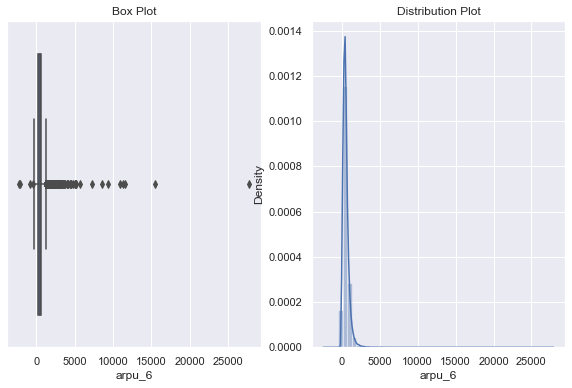

count    21001.000000
mean       538.233159
std        480.753447
min      -2258.709000
25%        279.284000
50%        460.447000
75%        684.408000
max      27731.088000
Name: arpu_6, dtype: float64


In [326]:
univariate(df_train_filtered, 'arpu_6')

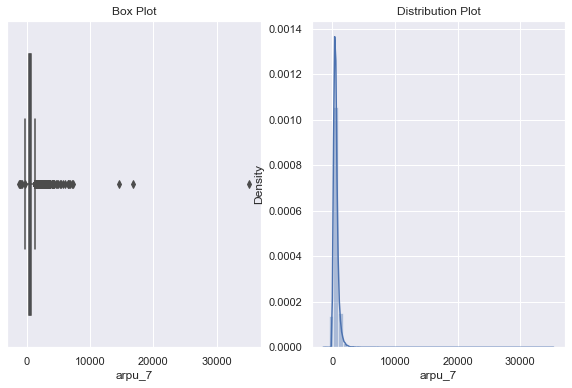

count    21001.000000
mean       554.883200
std        496.448295
min      -1289.715000
25%        300.883000
50%        476.909000
75%        695.703000
max      35145.834000
Name: arpu_7, dtype: float64


In [329]:
univariate(df_train_filtered, 'arpu_7')

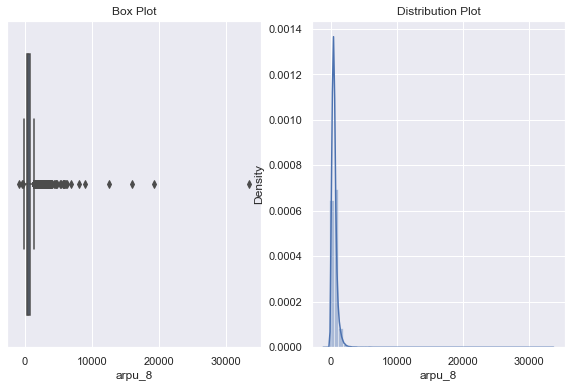

count    21001.000000
mean       548.392801
std        514.834686
min       -945.808000
25%        286.422000
50%        470.956000
75%        690.040000
max      33543.624000
Name: arpu_8, dtype: float64


In [330]:
univariate(df_train_filtered, 'arpu_8')

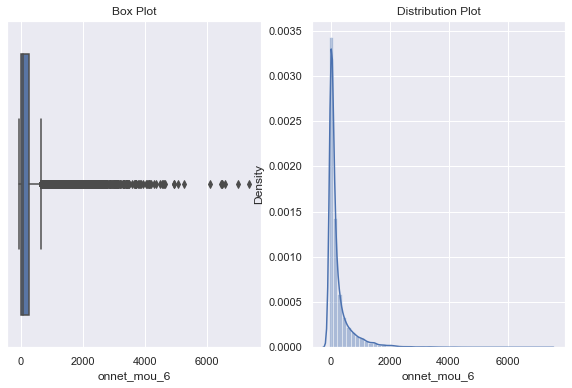

count    21001.000000
mean       248.020583
std        457.128235
min        -66.991269
25%         14.280000
50%         77.590000
75%        268.460000
max       7376.710000
Name: onnet_mou_6, dtype: float64


In [328]:
univariate(df_train_filtered, 'onnet_mou_6')

In [ ]:
univariate(df_train_filtered, 'onnet_mou_7')

In [ ]:
univariate(df_train_filtered, 'onnet_mou_8')

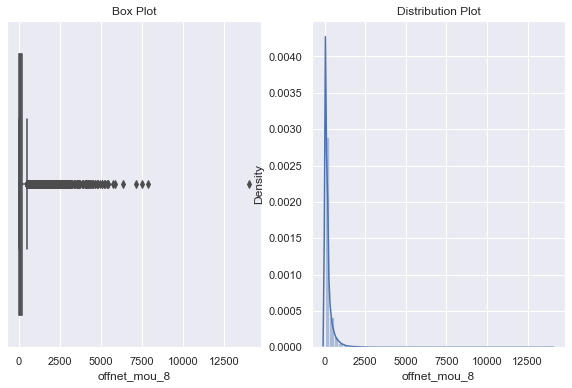

count    69999.000000
mean       195.724213
std        315.419532
min          0.000000
25%         34.390000
50%        101.680000
75%        216.410000
max      14007.340000
Name: offnet_mou_8, dtype: float64


In [219]:
univariate(df_train_filtered, 'offnet_mou_6')

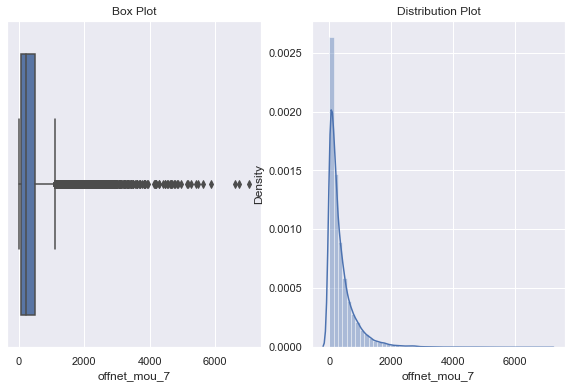

count    21001.000000
mean       377.883651
std        489.902779
min          0.000000
25%         76.710000
50%        215.110000
75%        490.560000
max       7043.980000
Name: offnet_mou_7, dtype: float64


In [331]:
univariate(df_train_filtered, 'offnet_mou_7')

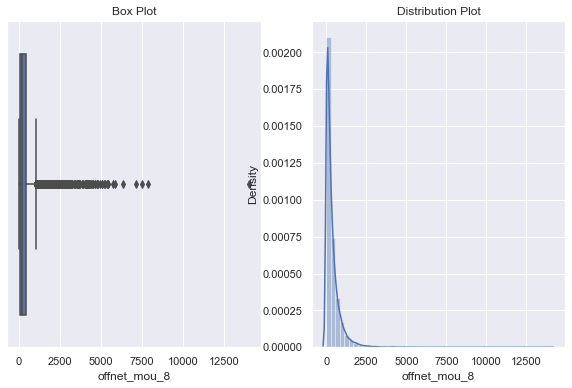

count    21001.000000
mean       364.118460
std        487.490275
min          0.000000
25%         70.430000
50%        207.780000
75%        470.080000
max      14007.340000
Name: offnet_mou_8, dtype: float64


In [332]:
univariate(df_train_filtered, 'offnet_mou_8')

Observation: Variables are very skewed towards the left. with many outliers

#### Plot Categorical Data

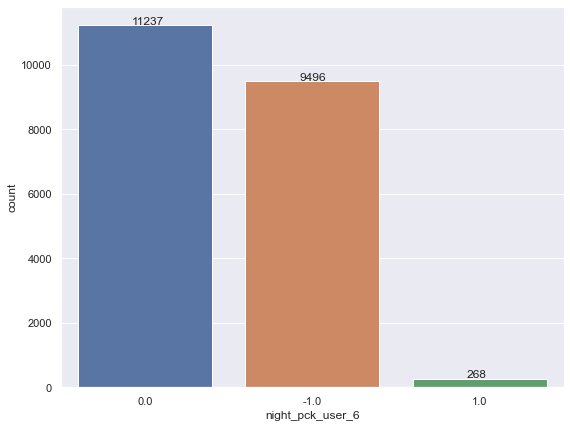

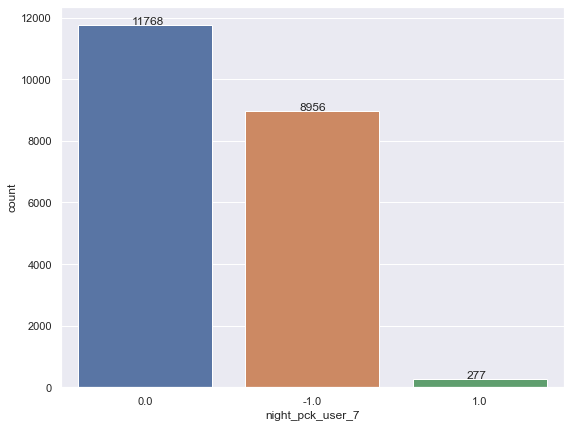

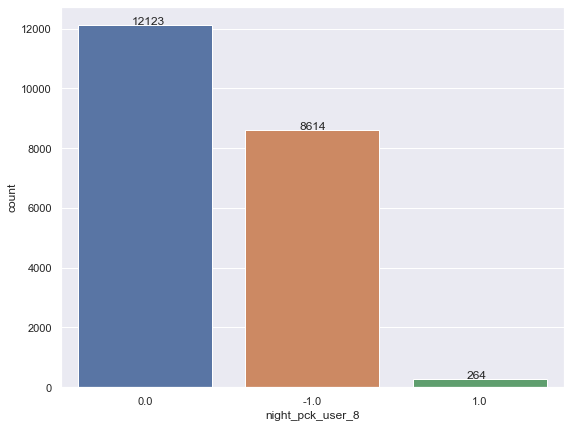

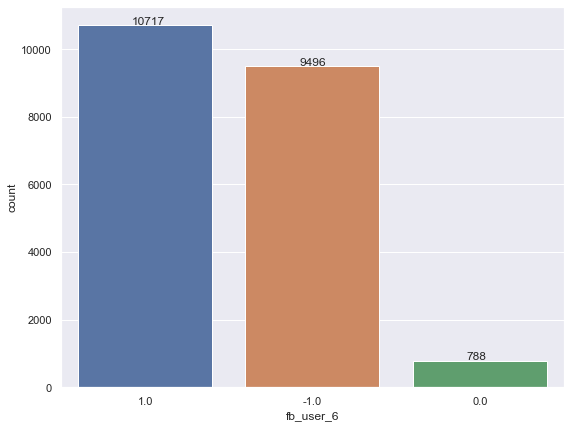

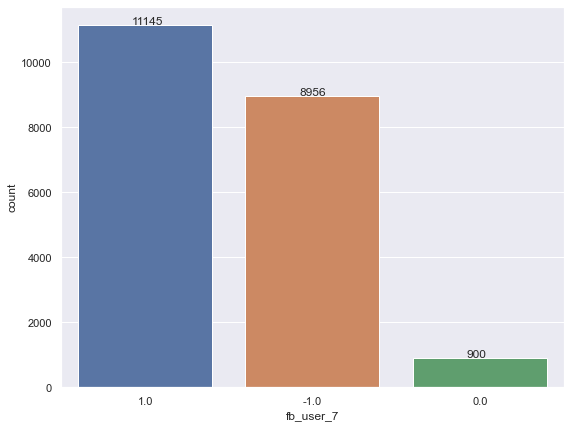

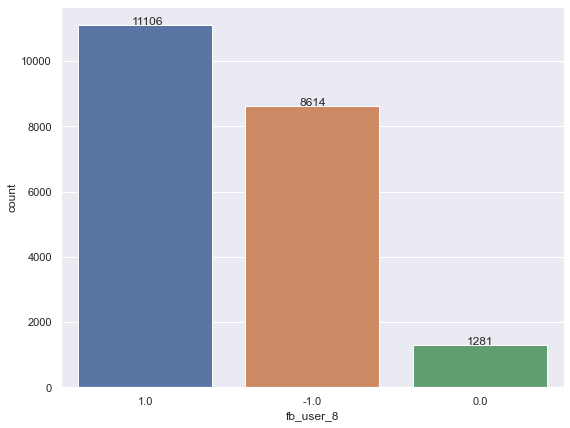

In [333]:
# Plotting Categorical Data with a loop
for col in cat_cols:
    # Plotting Categorical Data:
    univar_plot_byCheckingColTyp(df_train_filtered, col, 1)

Observation: We can see there data is well adjusted for category columns and for numerical columns there are outliyers which we treat them later


#### Bivariable Analysis

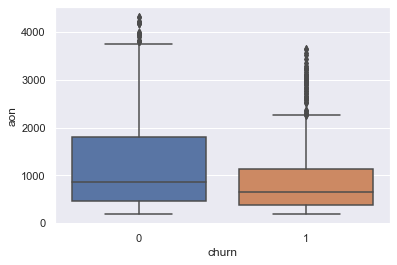

In [334]:
bivariate(df_train_filtered, 'churn', 'aon')

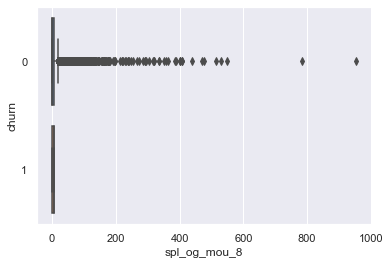

In [335]:
bivariate(df_train_filtered, 'spl_og_mou_8', 'churn')

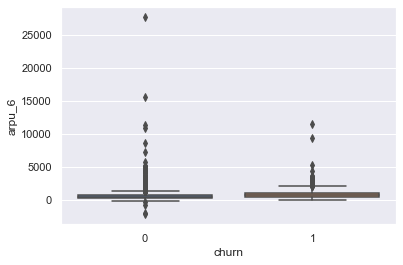

In [337]:
bivariate(df_train_filtered, 'churn', 'arpu_6')

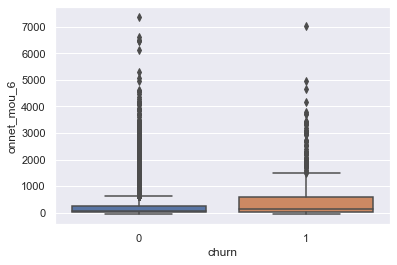

In [338]:
bivariate(df_train_filtered, 'churn', 'onnet_mou_6')

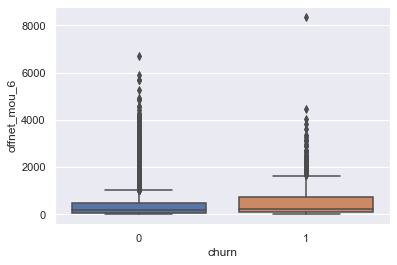

In [339]:
bivariate(df_train_filtered, 'churn', 'offnet_mou_6')

In [340]:
pd.crosstab(df_train_filtered.churn, df_train_filtered.night_pck_user_8, normalize='columns')*100

night_pck_user_8,-1.0,0.0,1.0
churn,,,
0,93.359647,99.843273,100.0
1,6.640353,0.156727,0.0


In [341]:
pd.crosstab(df_train_filtered.churn, df_train_filtered.sachet_3g_8)

sachet_3g_8,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,23.0,25.0,29.0,30.0,38.0,41.0
churn,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,18191,1379,348,165,87,71,35,29,24,16,11,9,9,9,3,4,2,2,3,1,3,2,2,1,1,1,1,1
1,591,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Index(['total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8',
       'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8',
       'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8',
       'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8',
       'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8'],
      dtype='object')


<AxesSubplot:>

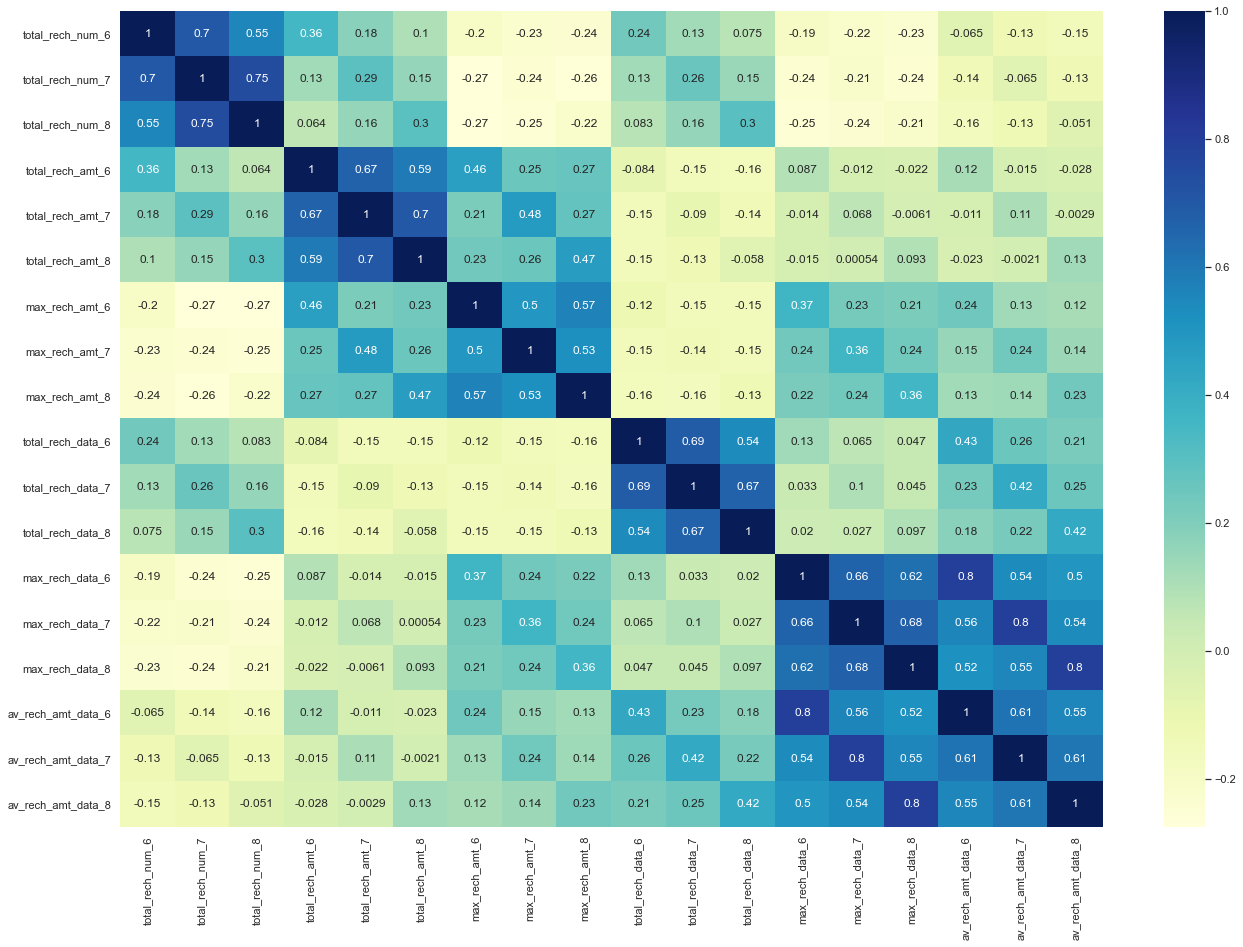

In [343]:
#Histogram to check the co-relation
rech_df = df_train_filtered.filter(regex = 'rech')
print(rech_df.columns)
fig = plt.figure(figsize=(22, 15))
sns.heatmap(rech_df.corr(), annot = True, cmap="YlGnBu")
plt.show()

Index(['roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'loc_ic_mou_6',
       'loc_ic_mou_7', 'loc_ic_mou_8', 'std_ic_mou_6', 'std_ic_mou_7',
       'std_ic_mou_8', 'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8',
       'spl_ic_mou_6', 'spl_ic_mou_7', 'spl_ic_mou_8', 'isd_ic_mou_6',
       'isd_ic_mou_7', 'isd_ic_mou_8'],
      dtype='object')


<AxesSubplot:>

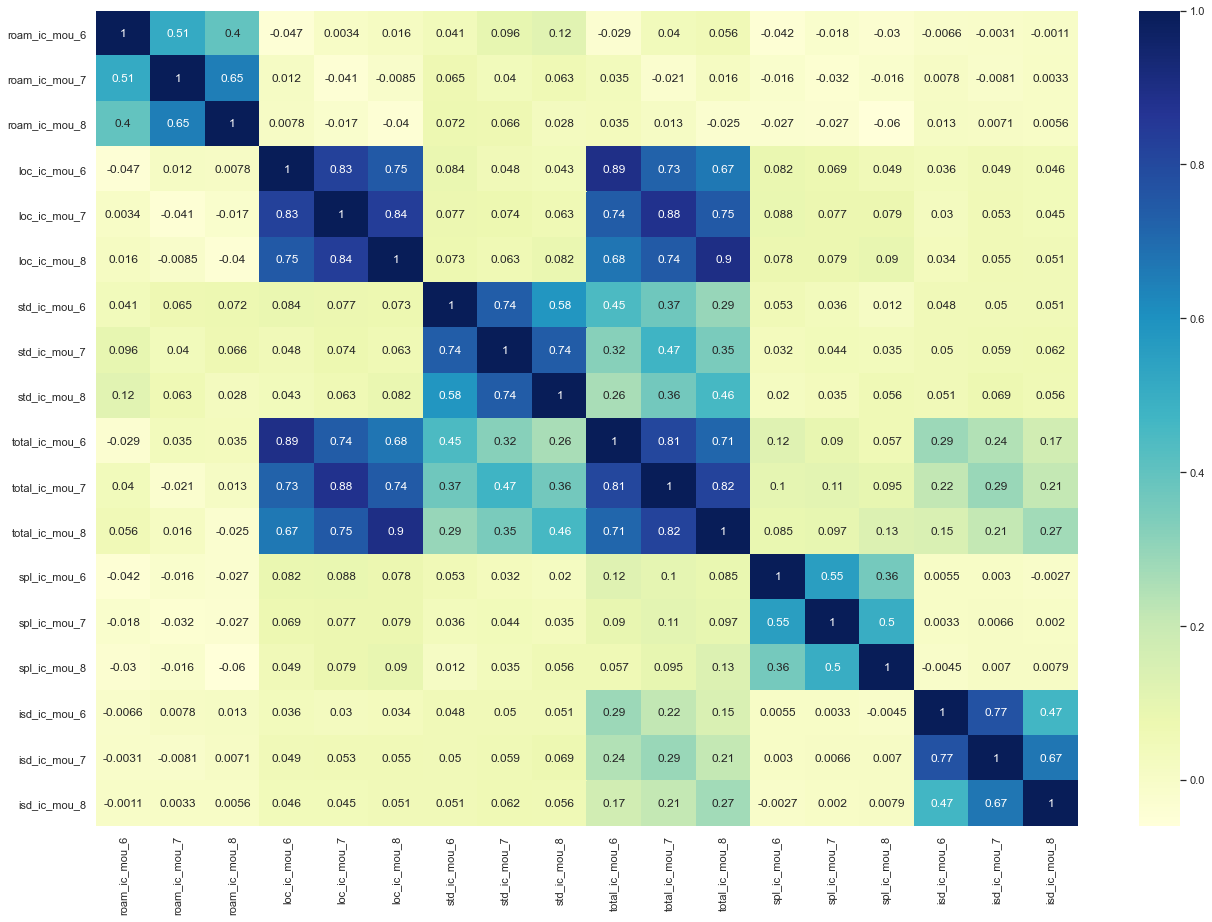

In [344]:
rech_df = df_train_filtered.filter(regex = 'ic_mou')
print(rech_df.columns)
fig = plt.figure(figsize=(22, 15))
sns.heatmap(rech_df.corr(), annot = True, cmap="YlGnBu")
plt.show()

Index(['roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_mou_6',
       'loc_og_mou_7', 'loc_og_mou_8', 'std_og_mou_6', 'std_og_mou_7',
       'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8',
       'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'total_og_mou_6',
       'total_og_mou_7', 'total_og_mou_8'],
      dtype='object')


<AxesSubplot:>

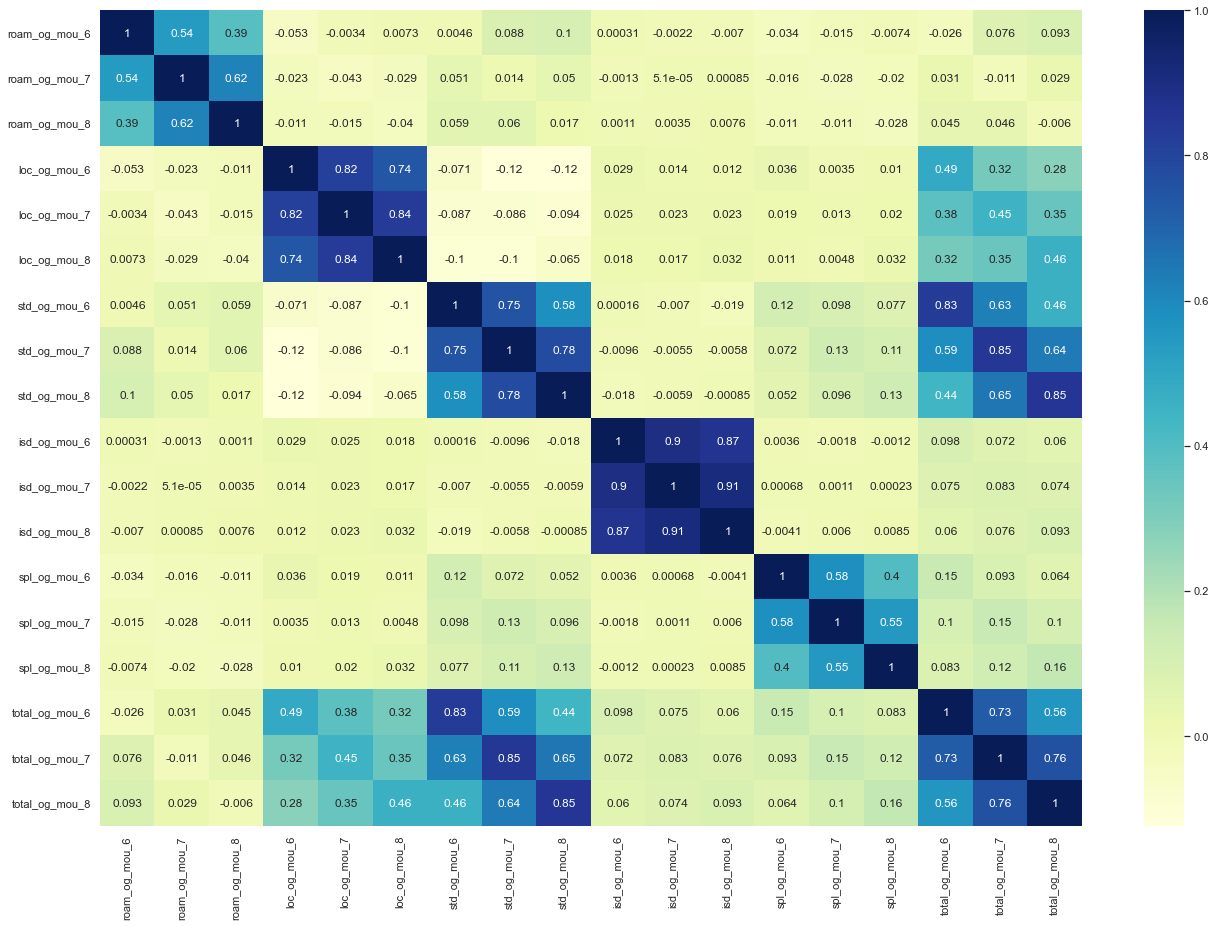

In [345]:
rech_df = df_train_filtered.filter(regex = 'og_mou')
print(rech_df.columns)
fig = plt.figure(figsize=(22, 15))
sns.heatmap(rech_df.corr(), annot = True, cmap="YlGnBu")
plt.show()

able to see there are some columns which are highly co-related with each other. 

#### standard deviation outlier treatment

In [346]:
num_cols = [col for col in df_train_filtered.columns if col in num_cols]
cat_cols = [col for col in df_train_filtered.columns if col in cat_cols]

In [348]:
# cap outliers in the numeric columns
df_train_filtered[num_cols] = df_train_filtered[num_cols].apply(std_dev_cap_outliers, axis=0)

In [349]:
df_train_filtered.describe()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
count,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000,21001.000000
mean,535.389683,552.092059,545.189611,247.364706,264.795707,250.937439,362.389699,377.604197,363.254404,15.590031,11.909888,12.816630,25.781563,18.983058,19.336213,81

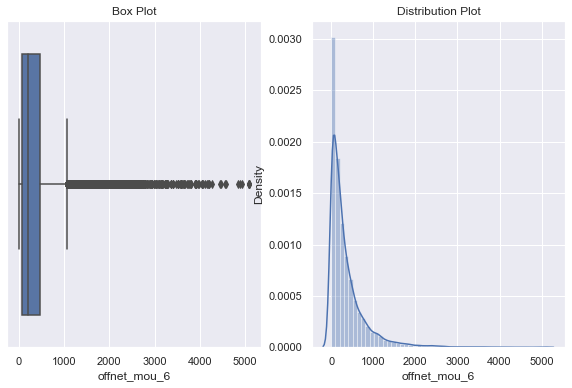

count    21001.000000
mean       362.389699
std        468.971365
min          0.000000
25%         73.340000
50%        207.310000
75%        467.260000
max       5093.644734
Name: offnet_mou_6, dtype: float64


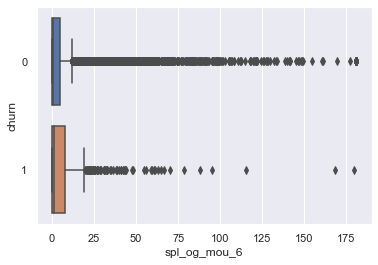

In [352]:
# Validate previous Univariable and Bivariable squewness
univariate(df_train_filtered, 'offnet_mou_6')
bivariate(df_train_filtered, 'spl_og_mou_6', 'churn')

#### Preparing the Data for Modeling

In [353]:
# change churn to numeric
df_train_filtered['churn'] = pd.to_numeric(df_train_filtered['churn'])

#### Splitting TRAIN data into Train Test

In [354]:
df_train_filtered

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn
0,240.708,128.191,101.565,21.28,4.83,6.13,56.99,38.11,9.63,53.64,0.0,0.00,15.73,0.0,0.00,10.16,4.83,6.13,36.74,19.88,4.61,11.99,1.23,5.01,0.00,9.85,0.00,58.91,25.94,15.76,0.00,0.00,0.00,4.35,0.00,0.00,0.00,0.00,0.00,4.35,0.00,0.00,0.00,0.00,0.00,0.00,17.00,0.00,0.0,0.0,0.0,63.26,42.94,15.76,5.44,1.39,2.66,10.58,4.33,19.49,5.51,3.63,6.14,21.54,9.36,28.31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,21.54,9.36,28.31,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.0,13.0,10.0,8.0,290.0,136.0,122.0,50.0,41.0,30.0,25.0,10.0,30.0,7.0,7.0,6.0,25.0,41.0,25.0,175.0,191.0,142.0,390.80,308.89,213.47,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,7.0,6.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,647.0,0.00,0.00,0.00,0
1,580.549,377.294,338.286,10.43,24.99,194.43,317.11,341.79,197.09,0.00,0.0,0.00,0.00,0.0,0.00,10.43,24.99,194.43,313.76,330.88,185.88,3.26,10.91,4.94,0.00,0.00,0.00,327.46,366.79,385.26,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6.26,0.00,0.00,6.26,0.00,0.00,0.00,0.08,0.00,0.00,0.1,0.0,0.0,327.64,366.79,391.53,13.86,20.18,335.43,219.31,754.24,285.63,0.00,1.93,8.88,233.18,776.36,629.94,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.03,0.00,0.00,1.03,0.00,233.18,777.39,629.94,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.0,5.0,3.0,4.0,654.0,400.0,652.0,250.0,250.0,250.0,0.0,150.0,250.0,1.0,0.0,1.0,154.0,0.0,154.0,154.0,0.0,154.0,260.42,0.00,354.35,0.00,0.00,0.00,0.0,-1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,1.0,602.0,0.00,0.00,0.00,0
2,1130.948,905.506,479.762,859.53,372.71,0.89,293.46,450.11,386.91,0.00,0.0,0.00,0.00,0.0,0.00,859.53,372.71,0.89,79.79,424.63,378.01,11.58,25.43,8.88,0.00,0.00,0.00,950.91,822.78,387.79,0.00,0.00,0.00,202.08,0.00,0.00,0.00,0.00,0.00,202.08,0.00,0.00,0.00,0.00,0.00,0.00,0.05,0.01,0.0,0.0,0.0,1152.99,822.83,387.81,233.28,117.63,30.39,123.78,278.49,148.83,34.31,52.08,23.66,391.38,448.21,202.89,0.00,0.00,0.00,207.03,0.00,0.00,0.00,0.00,0.00,207.03,0.00,0.00,598.54,448.36,203.29,0.13,0.00,0.0,0.00,0.00,0.00,0.0,

In [355]:
# divide data into train and test
X = df_train_filtered.drop("churn", axis = 1)
y = df_train_filtered.churn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 4, stratify = y)

In [356]:
X_TEST_CSV = df_test_filtered

In [357]:
# print shapes of train and test sets
X_train.shape
y_train.shape
X_test.shape
y_test.shape
X_TEST_CSV.shape


(15750, 139)

(15750,)

(5251, 139)

(5251,)

(30000, 139)

#### Aggregating the Categorical columns

In [358]:
train = pd.concat([X_train, y_train], axis=1)

train.groupby('night_pck_user_6').churn.mean()
train.groupby('night_pck_user_7').churn.mean()
train.groupby('night_pck_user_8').churn.mean()
train.groupby('fb_user_6').churn.mean()
train.groupby('fb_user_7').churn.mean()
train.groupby('fb_user_8').churn.mean()

night_pck_user_6
-1.0    0.032357
 0.0    0.024039
 1.0    0.048077
Name: churn, dtype: float64

night_pck_user_7
-1.0    0.043109
 0.0    0.017087
 1.0    0.014354
Name: churn, dtype: float64

night_pck_user_8
-1.0    0.066326
 0.0    0.001650
 1.0    0.000000
Name: churn, dtype: float64

fb_user_6
-1.0    0.032357
 0.0    0.038462
 1.0    0.023635
Name: churn, dtype: float64

fb_user_7
-1.0    0.043109
 0.0    0.035346
 1.0    0.015537
Name: churn, dtype: float64

fb_user_8
-1.0    0.066326
 0.0    0.015512
 1.0    0.000000
Name: churn, dtype: float64

In [359]:
# Replace categories with aggregated values in each categorical column
mapping = {'night_pck_user_6' : {-1: 0.032357, 0: 0.024039, 1: 0.048077},
           'night_pck_user_7' : {-1: 0.043109, 0: 0.017087, 1: 0.014354},
           'night_pck_user_8' : {-1: 0.066326, 0: 0.001650, 1: 0.000000},
           'fb_user_6'        : {-1: 0.032357, 0: 0.038462, 1: 0.023635},
           'fb_user_7'        : {-1: 0.043109, 0: 0.035346, 1: 0.015537},
           'fb_user_8'        : {-1: 0.066326, 0: 0.015512, 1: 0.000000}
          }
X_train.replace(mapping, inplace = True)
X_test.replace(mapping, inplace = True)

# for TEST
X_TEST_CSV.replace(mapping, inplace = True)

In [360]:
# Replace categories with aggregated values in each categorical column for TEST
X_TEST_CSV.replace(mapping, inplace = True)

In [361]:
# check data type of categorical columns - make sure they are numeric
X_train[[col for col in cat_cols if col not in ['churn']]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15750 entries, 349 to 14392
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   night_pck_user_6  15750 non-null  float64
 1   night_pck_user_7  15750 non-null  float64
 2   night_pck_user_8  15750 non-null  float64
 3   fb_user_6         15750 non-null  float64
 4   fb_user_7         15750 non-null  float64
 5   fb_user_8         15750 non-null  float64
dtypes: float64(6)
memory usage: 861.3 KB


In [362]:
#for TEST
X_TEST_CSV[[col for col in cat_cols]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   night_pck_user_6  30000 non-null  float64
 1   night_pck_user_7  30000 non-null  float64
 2   night_pck_user_8  30000 non-null  float64
 3   fb_user_6         30000 non-null  float64
 4   fb_user_7         30000 non-null  float64
 5   fb_user_8         30000 non-null  float64
dtypes: float64(6)
memory usage: 1.4 MB


#### PCA - Principal Component Analysis

In [363]:
# Apply PCA to train data
pca = Pipeline([('scaler', StandardScaler()), ('pca', PCA())])

In [364]:
pca.fit(X_train)
churn_pca = pca.fit_transform(X_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA())])

In [365]:
# Extract PCA model from pipeline
pca = pca.named_steps['pca']

# PCA components
print(pd.Series(np.round(pca.explained_variance_ratio_.cumsum(), 4)*100))

0       12.15
1       21.56
2       27.74
3       32.36
4       36.62
5       39.88
6       42.73
7       45.38
8       47.85
9       50.28
10      52.55
11      54.79
12      56.86
13      58.76
14      60.52
15      62.18
16      63.69
17      65.06
18      66.42
19      67.69
20      68.96
21      70.10
22      71.21
23      72.31
24      73.30
25      74.26
26      75.19
27      76.10
28      76.95
29      77.74
30      78.50
31      79.24
32      79.94
33      80.60
34      81.24
35      81.85
36      82.46
37      83.05
38      83.63
39      84.20
40      84.75
41      85.30
42      85.83
43      86.31
44      86.79
45      87.26
46      87.71
47      88.16
48      88.57
49      88.97
50      89.36
51      89.74
52      90.12
53      90.47
54      90.81
55      91.12
56      91.44
57      91.75
58      92.05
59      92.35
60      92.64
61      92.92
62      93.20
63      93.46
64      93.72
65      93.97
66      94.22
67      94.46
68      94.68
69      94.90
70      95.11
71    

<Figure size 630x360 with 0 Axes>

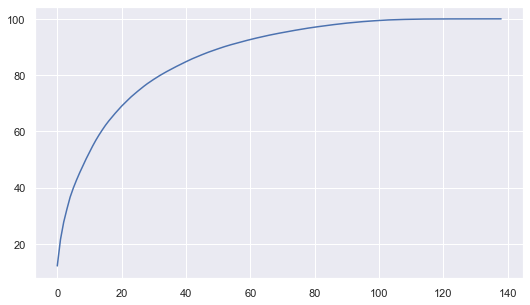

In [366]:
# Plot feature variance
features = range(pca.n_components_)
cumulative_variance = np.round(np.cumsum(pca.explained_variance_ratio_)*100, decimals=4)
plt.figure(figsize=(175/20, 100/20)) # 100 elements on y-axis; 175 elements on x-axis; 20 is normalising factor
plt.plot(cumulative_variance)


Obervation
* 60 components explain 93.20% variance
* 80 components explain 97.23% variance
* 100 components explain 99.30% variance

#### Model Building

Implementing the Model using Logistic Regression, Random Forest, CrossValidation from SciKit Learn

##### PCA and Logistic Regression

In [367]:
# Create Pipeline with Scaler, PCA, and modeling with LogisticRegression
PCA_VARS = 60
steps = [('scaler', StandardScaler()),
         ("pca", PCA(n_components=PCA_VARS)),
         ("logistic", LogisticRegression(class_weight = 'balanced'))
        ]
pipeline_pca_rl = Pipeline(steps)

In [368]:
# fit model
pipeline_pca_rl.fit(X_train, y_train)

# check score on train data
pipeline_pca_rl.score(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=60)),
                ('logistic', LogisticRegression(class_weight='balanced'))])

0.9826666666666667

#### Evaluate on train_test data

In [369]:
# predict churn on test data
y_pred = pipeline_pca_rl.predict(X_test)

# create onfusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Check Precision, Accuracy, Recall and F1-Score
print("Precision: ", round(precision_score(y_test, y_pred),4))
print("Accuracy: ",  round(accuracy_score(y_test, y_pred),4))
print("Recall: ",    round(recall_score(y_test, y_pred),4))
print("F1-Score: ",  round(f1_score(y_test, y_pred),4))

# Check area under curve
y_pred_prob = pipeline_pca_rl.predict_proba(X_test)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),4))

[[4989  114]
 [   8  140]]
Precision:  0.5512
Accuracy:  0.9768
Recall:  0.9459
F1-Score:  0.6965
AUC:    	 0.9959


#### Evaluate on TEST_CSV data

In [370]:
# predict churn on test_csv data
y_pred_test_csv_lr = pipeline_pca_rl.predict(X_TEST_CSV)

In [373]:
#creating the file to test in kaggle
#y_rf = pd.DataFrame(y_pred_test_csv_lr)
#result = pd.concat([df_test_unseen.id, y_rf], axis=1, ignore_index=True)
#result = result.rename(columns={0: "id", 1: "churn_probability"})
#result.to_csv(RESULT_TEST_FILEPATH, index=False)
#result
#kaggle score is 0.91390

#### Hyperparameter Tuning for PCA and Logistic Regression

In [374]:
# class imbalance
y_train.value_counts() / y_train.shape

0    0.971873
1    0.028127
Name: churn, dtype: float64

In [375]:
# PCA
pca = PCA()

# Logistic Regression - the class weight is used to handle class imbalance
# It adjusts the cost function
logistic = LogisticRegression(class_weight={0: 0.1, 1: 0.9})

# Create pipeline
steps = [("scaler", StandardScaler()), 
         ("pca", pca),
         ("logistic", logistic)
        ]

# Compile Pipeline
pipeline_pca_rl_tunned = Pipeline(steps)

# Hyperparameter Space
params = {'pca__n_components': [60, 80], 'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10], 'logistic__penalty': ['l1', 'l2']}

# Create 5 Folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

# create gridsearch object
rl_model_tunned = GridSearchCV(estimator=pipeline_pca_rl_tunned, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=1)


In [376]:
# Fit Model
rl_model_tunned.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('logistic',
                                        LogisticRegression(class_weight={0: 0.1,
                                                                         1: 0.9}))]),
             n_jobs=-1,
             param_grid={'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10],
                         'logistic__penalty': ['l1', 'l2'],
                         'pca__n_components': [60, 80]},
             scoring='roc_auc', verbose=1)

In [377]:
# Cross Validation Results
pd.DataFrame(rl_model_tunned.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logistic__C,param_logistic__penalty,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.396067,0.073795,0.000000,0.000000,0.1,l1,60,"{'logistic__C': 0.1, 'logistic__penalty': 'l1'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,32
1,1.529777,0.114780,0.000000,0.000000,0.1,l1,80,"{'logistic__C': 0.1, 'logistic__penalty': 'l1'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,19
2,1.667944,0.104445,0.035642,0.004479,0.1,l2,60,"{'logistic__C': 0.1, 'logistic__penalty': 'l2'...",0.996998,0.990726,0.995709,0.997401,0.997181,0.995603,0.002509,15
3,2.062055,0.118611,0.050067,0.011989,0.1,l2,80,"{'logistic__C': 0.1, 'logistic__penalty': 'l2'...",0.996612,0.989505,0.995922,0.997698,0.997291,0.995406,0.003012,16
4,1.266907,0.060564,0.000000,0.000000,0.5,l1,60,"{'logistic__C': 0.5, 'logistic__penalty': 'l1'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,22
5,1.579966,0.039361,0.000000,0.000000,0.5,l1,80,"{'logistic__C': 0.5, 'logistic__penalty': 'l1'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,25
6,1.977116,0.102838,0.040890,0.004886,0.5,l2,60,"{'logistic__C': 0.5, 'logistic__penalty': 'l2'...",0.993724,0.991828,0.996961,0.997922,0.997654,0.995618,0.002417,14
7,2.251396,0.102859,0.041165,0.006071,0.5,l2,80,"{'logistic__C': 0.5, 'logistic__penalty': 'l2'...",0.994775,0.990035,0.997089,0.998242,0.997977,0.995624,0.003049,13
8,1.130700,0.035902,0.000000,0.000000,1,l1,60,"{'logistic__C': 1, 'logistic__penalty': 'l1', ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,28
9,1.486611,0.077812,0.000000,0.000000,1,l1,80,"{'logistic__C': 1, 'logistic__penalty': 'l1', ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,31


In [378]:
# Print Best Hyperparameters
print("Best AUC: ", rl_model_tunned.best_score_)
print("Best HyperParameters: ", rl_model_tunned.best_params_)

Best AUC:  0.9960518286500643
Best HyperParameters:  {'logistic__C': 10, 'logistic__penalty': 'l2', 'pca__n_components': 80}


In [379]:
# Predict Churn on Train.Test Data
y_pred = rl_model_tunned.predict(X_test)

# Create Confusion Matrix again
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Check Precision, Accuracy, Recall and F1-Score
print("Precision: ", round(precision_score(y_test, y_pred),4))
print("Accuracy: ",  round(accuracy_score(y_test, y_pred),4))
print("Recall: ",    round(recall_score(y_test, y_pred),4))
print("F1-Score: ",  round(f1_score(y_test, y_pred),4))

# Check area under curve
y_pred_prob = rl_model_tunned.predict_proba(X_test)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),4))

[[5042   61]
 [   9  139]]
Precision:  0.695
Accuracy:  0.9867
Recall:  0.9392
F1-Score:  0.7989
AUC:    	 0.9975


#### Evaluate on TEST_CSV data

In [380]:
# predict churn on test_csv data
y_pred_test_csv_lr_tunned = rl_model_tunned.predict(X_TEST_CSV)

In [381]:
#creating the file to test in kaggle
#y_rf = pd.DataFrame(y_pred_test_csv_lr_tunned)
#result = pd.concat([df_test_unseen.id, y_rf], axis=1, ignore_index=True)
#result = result.rename(columns={0: "id", 1: "churn_probability"})
#result.to_csv(RESULT_TEST_FILEPATH, index=False)
#result
#kaggle score is -

,id,churn_probability
0,69999,0
1,70000,0
2,70001,1
3,70002,0
4,70003,0
...,...,...
29995,99994,0
29996,99995,0
29997,99996,0
29998,99997,0


#### Random Forest

In [382]:
# Random Forest
## - The class weight is used to handle class imbalance - it adjusts the cost function
forest = RandomForestClassifier(class_weight={0:0.1, 1: 0.9}, n_jobs = -1)

# Hyperparameter space
params = {"criterion": ['gini', 'entropy'], "max_features": ['auto', 0.4]}

# Create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

# create gridsearch object
rf_model = GridSearchCV(estimator=forest, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=1)

In [383]:
# fit model
rf_model.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             estimator=RandomForestClassifier(class_weight={0: 0.1, 1: 0.9},
                                              n_jobs=-1),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 0.4]},
             scoring='roc_auc', verbose=1)

In [384]:
# print best hyperparameters
print("Best AUC: ", rf_model.best_score_)
print("Best hyperparameters: ", rf_model.best_params_)

Best AUC:  0.9999977732913722
Best hyperparameters:  {'criterion': 'gini', 'max_features': 0.4}


In [385]:
# predict churn on test data
y_pred = rf_model.predict(X_test)

# create onfusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Check Precision, Accuracy, Recall and F1-Score
print("Precision: ", round(precision_score(y_test, y_pred), 4))
print("Accuracy: ",  round(accuracy_score(y_test, y_pred), 4))
print("Recall: ",    round(recall_score(y_test, y_pred), 4))
print("F1-Score: ",  round(f1_score(y_test, y_pred), 4))

# Check area under curve
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),4))

[[5102    1]
 [   0  148]]
Precision:  0.9933
Accuracy:  0.9998
Recall:  1.0
F1-Score:  0.9966
AUC:    	 1.0


#### Evaluate on TEST_CSV data

In [386]:
# predict churn on test_csv data
y_pred_test_csv_rf = rf_model.predict(X_TEST_CSV)

In [387]:
#creating the file to test in kaggle
#y_rf = pd.DataFrame(y_pred_test_csv_rf)
#result = pd.concat([df_test_unseen.id, y_rf], axis=1, ignore_index=True)
#result = result.rename(columns={0: "id", 1: "churn_probability"})
#result.to_csv(RESULT_TEST_FILEPATH, index=False)
#result
#kaggle score is -

,id,churn_probability
0,69999,0
1,70000,0
2,70001,1
3,70002,0
4,70003,0
...,...,...
29995,99994,0
29996,99995,0
29997,99996,0
29998,99997,0


Observation: The best model is Random Forest with better Scores than LogisticRegression.

#### Choosing best features

In [388]:
# run a random forest model on train data
max_features = int(round(np.sqrt(X_train.shape[1])))    # number of variables to consider to split each node
print(max_features)

rf2_model = RandomForestClassifier(n_estimators=100, max_features=max_features, class_weight={0:0.1, 1: 0.9}, oob_score=True, random_state=4, verbose=1)

12


In [389]:
# Fit Model
rf2_model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished


RandomForestClassifier(class_weight={0: 0.1, 1: 0.9}, max_features=12,
                       oob_score=True, random_state=4, verbose=1)

In [390]:
# OOB Score
rf2_model.oob_score_

0.9996825396825397

In [391]:
len(X_train.columns)

139

In [392]:
# predict churn on test data
y_pred = rf2_model.predict(X_test)

# create confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Check Precision, Accuracy, Recall and F1-Score
print("Precision: ", round(precision_score(y_test, y_pred),4))
print("Accuracy: ",  round(accuracy_score(y_test, y_pred),4))
print("Recall: ",    round(recall_score(y_test, y_pred),4))
print("F1-Score: ",  round(f1_score(y_test, y_pred),4))

# Check area under curve
y_pred_prob = rf2_model.predict_proba(X_test)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),4))

[[5101    2]
 [   0  148]]
Precision:  0.9867
Accuracy:  0.9996
Recall:  1.0
F1-Score:  0.9933
AUC:    	 1.0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


#### Feature Importance

In [394]:
# Predictors
features = df_train_filtered.drop('churn', axis=1).columns

# Feature_Importance
importance = rf2_model.feature_importances_

# Create Dataframe
feature_importance = pd.DataFrame({'variables': features, 'importance_percentage': importance * 100})
feature_importance = feature_importance[['variables', 'importance_percentage']]

# Sort Features
feature_importance = feature_importance.sort_values('importance_percentage', ascending=False).reset_index(drop=True)
print("Sum of importance=", feature_importance.importance_percentage.sum())

feature_importance

Sum of importance= 100.0


,variables,importance_percentage
0,total_ic_mou_8,13.602546
1,loc_og_mou_8,10.489260
2,total_og_mou_8,10.445570
3,total_rech_amt_8,6.473793
4,std_ic_mou_8,5.234781
5,max_rech_amt_8,4.091653
6,roam_og_mou_8,4.068327
7,roam_ic_mou_8,3.840079
8,arpu_8,3.434419
9,loc_ic_t2m_mou_8,3.176531


#### Extracting Top 20 features

In [395]:
# extract top 'n' features
top_n = 20
top_features = feature_importance.variables[0:top_n]

<AxesSubplot:>

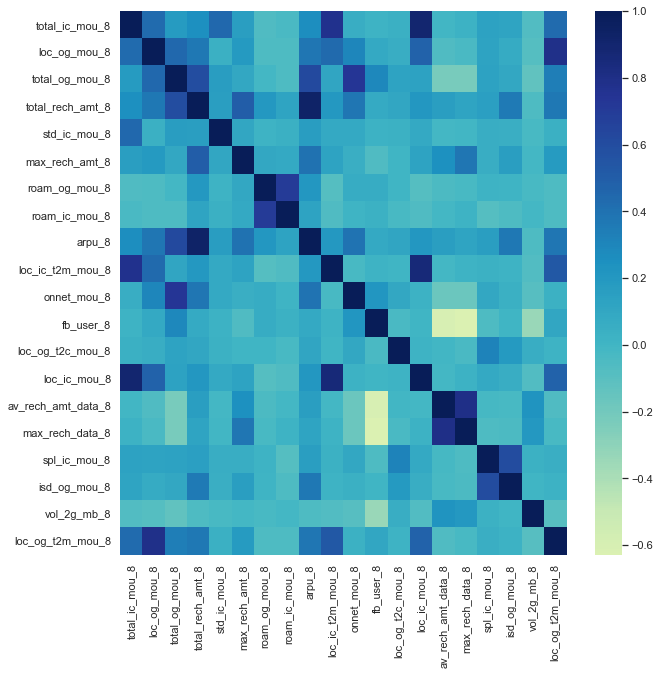

In [396]:
# plot feature correlation
plt.rcParams["figure.figsize"] = (10,10)
mycmap = sns.diverging_palette(199, 359, s=99, center="light", as_cmap=True)
sns.heatmap(data=X_train[top_features].corr(), center=0.0, cmap='YlGnBu')

In [397]:
top_features

0         total_ic_mou_8
1           loc_og_mou_8
2         total_og_mou_8
3       total_rech_amt_8
4           std_ic_mou_8
5         max_rech_amt_8
6          roam_og_mou_8
7          roam_ic_mou_8
8                 arpu_8
9       loc_ic_t2m_mou_8
10           onnet_mou_8
11             fb_user_8
12      loc_og_t2c_mou_8
13          loc_ic_mou_8
14    av_rech_amt_data_8
15       max_rech_data_8
16          spl_ic_mou_8
17          isd_og_mou_8
18           vol_2g_mb_8
19      loc_og_t2m_mou_8
Name: variables, dtype: object

In [398]:
X_train = X_train[top_features]
X_test = X_test[top_features]

In [399]:
# Logistic Regression
steps = [('scaler', StandardScaler()), 
         ("logistic", LogisticRegression(class_weight={0:0.1, 1:0.9}))
        ]

# compile pipeline
logistic = Pipeline(steps)

# hyperparameter space
params = {'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10], 'logistic__penalty': ['l1', 'l2']}

# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

# create gridsearch object
model = GridSearchCV(estimator=logistic, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=1)

In [400]:
# Fit Model
model.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logistic',
                                        LogisticRegression(class_weight={0: 0.1,
                                                                         1: 0.9}))]),
             n_jobs=-1,
             param_grid={'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10],
                         'logistic__penalty': ['l1', 'l2']},
             scoring='roc_auc', verbose=1)

In [401]:
# Print best hyperparameters
print("Best AUC: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

Best AUC:  0.998366132034937
Best hyperparameters:  {'logistic__C': 10, 'logistic__penalty': 'l2'}


In [402]:
X_train.columns

Index(['total_ic_mou_8', 'loc_og_mou_8', 'total_og_mou_8', 'total_rech_amt_8',
       'std_ic_mou_8', 'max_rech_amt_8', 'roam_og_mou_8', 'roam_ic_mou_8',
       'arpu_8', 'loc_ic_t2m_mou_8', 'onnet_mou_8', 'fb_user_8',
       'loc_og_t2c_mou_8', 'loc_ic_mou_8', 'av_rech_amt_data_8',
       'max_rech_data_8', 'spl_ic_mou_8', 'isd_og_mou_8', 'vol_2g_mb_8',
       'loc_og_t2m_mou_8'],
      dtype='object')

#### Prepare the Test.csv Predictions file for Kraggle

In [404]:
y_lr = pd.DataFrame(y_pred_test_csv_lr)
y_lr_tunned = pd.DataFrame(y_pred_test_csv_lr_tunned) 
y_rf = pd.DataFrame(y_pred_test_csv_rf)

X_TEST_CSV.head()
df_test_unseen.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,91.882,65.330,64.445,31.78,20.23,23.11,60.16,32.16,34.83,0.00,0.00,0.00,0.00,0.00,0.00,24.88,20.23,21.06,18.13,10.89,8.36,0.00,13.58,0.00,0.0,0.00,0.03,43.01,44.71,29.43,6.90,0.00,2.05,42.03,7.68,26.43,0.0,0.0,0.0,48.93,7.68,28.48,0.0,0.0,0.0,0.00,0.00,0.03,0.0,0.0,0.0,91.94,52.39,57.94,30.33,37.56,21.98,10.21,4.59,9.53,0.26,0.00,0.00,40.81,42.16,31.51,0.00,0.00,0.00,0.36,1.04,4.34,0.0,0.0,0.00,0.36,1.04,4.34,41.73,43.56,36.26,0.54,0.34,0.39,0.00,0.00,0.00,0.0,0.0,0.00,5.0,5.0,4.0,103.0,90.0,60.0,50.0,30.0,30.0,30.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.032357,0.043109,0.066326,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.032357,0.043109,0.066326,1692.0,0.00,0.00,0.00
1,414.168,515.568,360.868,75.51,41.21,19.84,474.34,621.84,394.94,0.00,0.00,0.00,0.00,0.00,0.00,75.51,41.21,19.84,473.61,598.08,377.26,0.73,0.00,0.00,0.0,0.00,0.00,549.86,639.29,397.11,0.00,0.00,0.00,0.00,23.76,17.68,0.0,0.0,0.0,0.00,23.76,17.68,0.0,0.0,0.8,0.00,0.00,0.00,0.0,0.0,0.0,549.86,663.06,415.59,19.99,26.95,2.61,160.19,122.29,184.81,1.49,0.00,0.00,181.69,149.24,187.43,0.00,0.00,0.00,0.00,12.51,0.00,0.0,0.0,0.00,0.00,12.51,0.00,296.33,339.64,281.66,0.00,0.00,0.00,114.63,177.88,94.23,0.0,0.0,0.00,5.0,4.0,5.0,500.0,500.0,500.0,250.0,250.0,250.0,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.032357,0.043109,0.066326,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.032357,0.043109,0.066326,2533.0,0.00,0.00,0.00
2,329.844,434.884,746.239,7.54,7.86,8.40,16.98,45.81,45.04,22.81,103.38,26.08,24.53,53.68,54.44,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,6.0,9.0,5.0,500.0,1000.0,1000.0,300.0,500.0,500.0,0

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,64.445,31.78,20.23,23.11,60.16,32.16,34.83,0.00,0.00,0.00,0.00,0.00,0.00,24.88,20.23,21.06,18.13,10.89,8.36,0.00,13.58,0.00,0.0,0.00,0.03,43.01,44.71,29.43,6.90,0.00,2.05,42.03,7.68,26.43,0.0,0.0,0.0,0.0,0.0,0.0,48.93,7.68,28.48,0.0,0.0,0.0,0.00,0.00,0.03,0.0,0.0,0.0,91.94,52.39,57.94,30.33,37.56,21.98,10.21,4.59,9.53,0.26,0.00,0.00,40.81,42.16,31.51,0.00,0.00,0.00,0.36,1.04,4.34,0.0,0.0,0.00,0.0,0.0,0.0,0.36,1.04,4.34,41.73,43.56,36.26,0.54,0.34,0.39,0.00,0.00,0.00,0.0,0.0,0.00,5,5,4,103,90,60,50,30,30,6/21/2014,7/26/2014,8/24/2014,30,30,0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,360.868,75.51,41.21,19.84,474.34,621.84,394.94,0.00,0.00,0.00,0.00,0.00,0.00,75.51,41.21,19.84,473.61,598.08,377.26,0.73,0.00,0.00,0.0,0.00,0.00,549.86,639.29,397.11,0.00,0.00,0.00,0.00,23.76,17.68,0.0,0.0,0.0,0.0,0.0,0.0,0.00,23.76,17.68,0.0,0.0,0.8,0.00,0.00,0.00,0.0,0.0,0.0,549.86,663.06,415.59,19.99,26.95,2.61,160.19,122.29,184.81,1.49,0.00,0.00,181.69,149.24,187.43,0.00,0.00,0.00,0.00,12.51,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,12.51,0.00,296.33,339.64,281.66,0.00,0.00,0.00,114.63,177.88,94.23,0.0,0.0,0.00,5,4,5,500,500,500,250,250,250,6/19/2014,7/16/2014,8/24/2014,250,0,0,NaN,NaN,Na

In [405]:
result = pd.concat([df_test_unseen.id, y_rf], axis=1, ignore_index=True)
result = result.rename(columns={0: "id", 1: "churn_probability"})


In [406]:
# Saving the result of the RandomForest model with the TEST Data
result.to_csv(RESULT_TEST_FILEPATH, index=False)

In [407]:
result

,id,churn_probability
0,69999,0
1,70000,0
2,70001,1
3,70002,0
4,70003,0
...,...,...
29995,99994,0
29996,99995,0
29997,99996,0
29998,99997,0


# Conclusions and Observations

In [285]:
## Comments
# * The best model is RandomForest with perfect scores 1.0 with the testing.
# * Preprocessing the data is important.
# * Kraggle Accuracy:  -
# Since the submition to Kraggle gave a 0.94374 Accuracy Score, seems that the Random Fores model overfitted.
# This can be given the data rows that are eliminated from the TRAIN Data, we do not have a treatement of similar rows in TEST_CSV data.